In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
from datetime import datetime
from scipy import integrate, optimize
import warnings
warnings.filterwarnings('ignore')

# ML libraries
import lightgbm as lgb
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, RidgeCV
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
counntries_df = pd.read_csv("/kaggle/input/countries-data/enriched_covid_19.csv")

In [ ]:
train_df = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/train.csv")
test_df = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/test.csv")
submission = pd.read_csv("/kaggle/input/covid19-global-forecasting-week-4/submission.csv")

In [56]:
train_df['Date'].max()

'2020-04-09'

In [ ]:
train_df.shape
#train_df.info()

In [ ]:
train_df["key"]=train_df[["Province_State","Country_Region"]].apply(lambda row: str(row[0]) + "_" + str(row[1]),axis=1)
test_df["key"]=test_df[["Province_State","Country_Region"]].apply(lambda row: str(row[0]) + "_" + str(row[1]),axis=1)

#test_new=pd.merge(test,train, how="left", left_on=["key","Date"], right_on=["key","Date"] )
#train.to_csv(directory + "transfomed.csv")

target1="ConfirmedCases"
target2="Fatalities"
key="key"
def rate(frame, key, target, new_target_name="rate"):
   
    corrections = 0
    group_keys = frame[ key].values.tolist()
    target = frame[target].values.tolist()
    rate=[1.0 for k in range (len(target))]

    for i in range(1, len(group_keys) - 1):
        previous_group = group_keys[i - 1]
        current_group = group_keys[i]

        previous_value = target[i - 1]
        current_value = target[i]
         
        if current_group == previous_group:
                if previous_value!=0.0:
                     rate[i]=current_value/previous_value

                 
        rate[i] =max(1,rate[i] )#correct negative values

    frame[new_target_name] = np.array(rate)

In [ ]:
dates_overlap = ['2020-03-26', '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30', '2020-03-31','2020-04-01', '2020-04-02', '2020-04-03']
train2 = train_df.loc[~train_df['Date'].isin(dates_overlap)]
all_data_train_test = pd.concat([train2, test_df], axis = 0, sort=False)

In [ ]:
all_data_train_test=train_df


In [ ]:
all_data_train_test['Province_State'].fillna('NONE', inplace=True)
all_data_train_test['ConfirmedCases'].fillna(0, inplace=True)
all_data_train_test['Fatalities'].fillna(0, inplace=True)
all_data_train_test['Id'].fillna(-1, inplace=True)
#all_data_train_test['ForecastId'].fillna(-1, inplace=True)

In [ ]:
all_data_train_test['mean_rate_case_last7']=1
all_data_train_test['mean_rate_fat_last7']=1
all_data_train_test['max_rate_case']=1
all_data_train_test['min_rate_case']=1
all_data_train_test['std_rate_case']=1
all_data_train_test['mode_rate_case']=1
all_data_train_test['range_rate_case']=1
all_data_train_test['max_to_min_rate_case']=1
all_data_train_test['max_rate_fat']=1
all_data_train_test['min_rate_fat']=1
all_data_train_test['std_rate_fat']=1
all_data_train_test['mode_rate_fat']=1
all_data_train_test['mean_rate_case']=1
all_data_train_test['mean_rate_fat']=1
all_data_train_test['range_rate_fat']=1        
all_data_train_test['max_to_min_rate_fat']=1        

In [ ]:
rate(all_data_train_test, key, target1, new_target_name="rate_" +target1)
rate(all_data_train_test, key, target2, new_target_name="rate_" +target2)
all_data_train_test.head()

In [ ]:
all_data_train_test[all_data_train_test['Country_Region']=='Italy'].tail(10)

In [ ]:
def infection_from_first_confirmed_cases(train_df,country):
    
    confirmed_cases = train_df[(train_df['Country_Region']==country_dict[country]) & train_df['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities_cases = train_df[(train_df['Country_Region']==country_dict[country]) & train_df['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
    total_cases = confirmed_cases.join(fatalities_cases)
    country_cases = [i for i in total_cases.ConfirmedCases['sum'].values]
    country_cases_filter = country_cases[0:70] 
       
    return country_cases_filter 

In [ ]:
#get the mean foe last seven vlaues for fatalities and confirmed cases
group_keys = all_data_train_test['key'].values.tolist()
for k in group_keys:
    all_data_train_test['mean_rate_case_last7'][all_data_train_test['key']==k]=all_data_train_test['rate_ConfirmedCases'][all_data_train_test['key']==k].tail(7).mean()
    all_data_train_test['mean_rate_fat_last7'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][all_data_train_test['key']==k].tail(7).mean()
    all_data_train_test['std_rate_case'][all_data_train_test['key']==k]=all_data_train_test['rate_ConfirmedCases'][(all_data_train_test['key']==k) & (all_data_train_test['ConfirmedCases']!=0)].std()
    all_data_train_test['max_rate_case'][all_data_train_test['key']==k]=all_data_train_test['rate_ConfirmedCases'][(all_data_train_test['key']==k) & (all_data_train_test['ConfirmedCases']!=0)].max()
    all_data_train_test['min_rate_case'][all_data_train_test['key']==k]=all_data_train_test['rate_ConfirmedCases'][(all_data_train_test['key']==k) & (all_data_train_test['ConfirmedCases']!=0)].min()
    all_data_train_test['mode_rate_case'][all_data_train_test['key']==k]=all_data_train_test['rate_ConfirmedCases'][(all_data_train_test['key']==k) & (all_data_train_test['ConfirmedCases']!=0)].mode()
    all_data_train_test['mean_rate_case'][all_data_train_test['key']==k]=all_data_train_test['rate_ConfirmedCases'][(all_data_train_test['key']==k) & (all_data_train_test['ConfirmedCases']!=0)].mean()
    all_data_train_test['std_rate_fat'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][(all_data_train_test['key']==k) & (all_data_train_test['Fatalities']!=0)].std()
    all_data_train_test['max_rate_fat'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][(all_data_train_test['key']==k) & (all_data_train_test['Fatalities']!=0)].max()
    all_data_train_test['min_rate_fat'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][(all_data_train_test['key']==k) & (all_data_train_test['Fatalities']!=0)].min()
    all_data_train_test['mode_rate_fat'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][(all_data_train_test['key']==k) & (all_data_train_test['Fatalities']!=0)].mode()
    all_data_train_test['mean_rate_fat'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][(all_data_train_test['key']==k) & (all_data_train_test['Fatalities']!=0)].mean()
    all_data_train_test['mean_rate_fat'][all_data_train_test['key']==k]=all_data_train_test['rate_Fatalities'][(all_data_train_test['key']==k) & (all_data_train_test['Fatalities']!=0)].mean()
    
all_data_train_test['range_rate_fat']=all_data_train_test['max_rate_fat']-all_data_train_test['min_rate_fat']
all_data_train_test['max_to_min_rate_fat']=all_data_train_test['max_rate_fat']/all_data_train_test['min_rate_fat']
all_data_train_test['range_rate_case']=all_data_train_test['max_rate_case']-all_data_train_test['min_rate_case']
all_data_train_test['max_to_min_rate_case']=all_data_train_test['max_rate_case']/all_data_train_test['min_rate_case']

In [ ]:

all_data_train_test['max_rate_fat'][all_data_train_test['Country_Region']=='Qatar'].tail(50)

In [ ]:
counntries_df.rename(columns={'Country/Region':'Country_Region','Province/State':'Province_State'},inplace = True)

In [ ]:
counntries_df.columns

In [ ]:
contries_data_columns=['Province_State', 'Country_Region', 'Lat', 'Long', 'Date',
       'ConfirmedCases', 'Fatalities', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools']

In [ ]:
grouped_countries=counntries_df.groupby(['Country_Region'], as_index=False).agg({"Lat": "max","Long": "max",'total_pop': "max",
                                                                                         'smokers_perc': "max",'density': "max",'urbanpop': "max",
                                                                                         'hospibed': "max",'lung': "max",'femalelung': "max",
                                                                                         'malelung': "max",'restrictions': "max",'quarantine': "max",
                                                                                         'schools': "max",'age_0-4': "max",'age_100+': "max",'age_5-9': "max",
                                                                                         'age_95-99': "max",'age_90-94': "max",'age_85-89': "max",
                                                                                         'age_80-84': "max",'age_75-79': "max",'age_70-74': "max",
                                                                                         'age_65-69': "max",'age_60-64': "max",'age_55-59': "max",
                                                                                         'age_50-54': "max",'age_45-49': "max",'age_40-44': "max",
                                                                                         'age_35-39': "max",'age_30-34': "max",'age_25-29': "max",
                                                                                         'age_20-24': "max",'age_15-19': "max",'age_10-14': "max",
                                                                                         })

In [ ]:
grouped_merged_train_df=merged_train_df.groupby(['key'], as_index=False).agg({"rate_ConfirmedCases": "mean","rate_Fatalities": "mean"})

In [ ]:
grouped_merged_train_df[grouped_merged_train_df['key']=='nan_Italy']

In [ ]:
merged_train_df = pd.merge(all_data_train_test,
                 grouped_countries[['Lat', 'Long','Country_Region',
        'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools']],
                 on='Country_Region',how='left')

In [ ]:
merged_train_df.shape

In [ ]:
merged_train_df

In [ ]:
merged_train_df[merged_train_df.isnull().any(axis=1)]

In [ ]:
train_df[train_df.isnull().any(axis=1)]

In [ ]:
merged_train_df['Province_State'].fillna('NONE', inplace=True)

In [ ]:
merged_train_df.fillna(0, inplace=True)

In [ ]:
merged_train_df.info()

In [ ]:
number_c = merged_train_df['Country_Region']
countries = (merged_train_df['Country_Region'])
country_dict = dict(zip(countries, number_c)) 
country_dict

In [ ]:
def countryplot(train_df,country):
    
    confirmed_total = train_df[train_df['Country_Region']==country_dict[country]].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities_total = train_df[train_df['Country_Region']==country_dict[country]].groupby(['Date']).agg({'Fatalities':['sum']})
    total = confirmed_total.join(fatalities_total)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
    total.plot(ax=ax1)
    ax1.set_title("Global confirmed cases", size=13,)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)
    fatalities_total.plot(ax=ax2, color='red')
    ax2.set_title("Global deceased cases", size=13)
    ax2.set_ylabel("Number of cases", size=13)
    ax2.set_xlabel("Date", size=13)

In [ ]:
country='US'
countryplot(train_df,country)

In [ ]:
def infection_from_first_confirmed_cases(train_df,country):
    
    confirmed_cases = train_df[(train_df['Country_Region']==country_dict[country]) & train_df['ConfirmedCases']!=0].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities_cases = train_df[(train_df['Country_Region']==country_dict[country]) & train_df['ConfirmedCases']!=0].groupby(['Date']).agg({'Fatalities':['sum']})
    total_cases = confirmed_cases.join(fatalities_cases)
    country_cases = [i for i in total_cases.ConfirmedCases['sum'].values]
    country_cases_filter = country_cases[0:70] 
       
    return country_cases_filter  

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(infection_from_first_confirmed_cases(train_df,'Italy'))
plt.plot(infection_from_first_confirmed_cases(train_df,'Spain'))
plt.plot(infection_from_first_confirmed_cases(train_df,'Singapore'))
plt.plot(infection_from_first_confirmed_cases(train_df,'United Kingdom'))
plt.plot(infection_from_first_confirmed_cases(train_df,'US'))
plt.legend(["Italy", "Spain", "UK", "Singapore",'U.S.A'], loc='upper left')
plt.title("COVID-19 infections from the first confirmed case", size=15)
plt.xlabel("Days", size=13)
plt.ylabel("Infected cases", size=13)
plt.ylim(0, 80000)
plt.show()

In [ ]:
merged_train_df.columns

In [ ]:
merged_train_df['Date_num'] = pd.to_datetime(merged_train_df['Date'])
merged_train_df['Date_num'] = merged_train_df['Date_num'].dt.strftime("%m%d")
merged_train_df['Date_num']

In [ ]:
merged_test_df['Date_num'] = pd.to_datetime(merged_test_df['Date'])
merged_test_df['Date_num'] = merged_test_df['Date_num'].dt.strftime("%m%d")
merged_test_df['Date_num']

In [ ]:
features_selector = ['Lat', 'Long', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools','Date_num']

In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
merged_train_df[['Lat', 'Long', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools']] = mms.fit_transform(merged_train_df[['Lat', 'Long', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools']])


In [ ]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
merged_test_df[['Lat', 'Long', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools']] = mms.fit_transform(merged_test_df[['Lat', 'Long', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools']])

In [ ]:
merged_train_df

In [ ]:
merged_test_df.fillna(0, inplace=True)

In [ ]:
merged_train_df['Date_num']=merged_train_df['Date_num'].astype('int')
merged_test_df['Date_num']=merged_test_df['Date_num'].astype('int')
merged_train_df.info()

# RNN

In [ ]:
features_selector = ['Lat', 'Long', 'age_0-4', 'age_5-9', 'age_10-14',
       'age_15-19', 'age_20-24', 'age_25-29', 'age_30-34', 'age_35-39',
       'age_40-44', 'age_45-49', 'age_50-54', 'age_55-59', 'age_60-64',
       'age_65-69', 'age_70-74', 'age_75-79', 'age_80-84', 'age_85-89',
       'age_90-94', 'age_95-99', 'age_100+', 'total_pop', 'smokers_perc',
       'density', 'urbanpop', 'hospibed', 'lung', 'femalelung', 'malelung',
       'restrictions', 'quarantine', 'schools','Date_num']

## Combined

In [ ]:
merged_train_df.columns

In [ ]:
#'rate_ConfirmedCases','rate_Fatalities',

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
merged_train_df[['mean_rate_case_last7', 'mean_rate_fat_last7',
       'max_rate_case', 'min_rate_case', 'std_rate_case', 'mode_rate_case',
       'max_rate_fat', 'min_rate_fat', 'std_rate_fat', 'mode_rate_fat',
       'mean_rate_case', 'mean_rate_fat', 'range_rate_case',
       'max_to_min_rate_case', 'range_rate_fat', 'max_to_min_rate_fat',
       'rate_ConfirmedCases', 'rate_Fatalities','total_pop', 'smokers_perc', 'density']] = mms.fit_transform(merged_train_df[['mean_rate_case_last7', 'mean_rate_fat_last7',
       'max_rate_case', 'min_rate_case', 'std_rate_case', 'mode_rate_case',
       'max_rate_fat', 'min_rate_fat', 'std_rate_fat', 'mode_rate_fat',
       'mean_rate_case', 'mean_rate_fat', 'range_rate_case',
       'max_to_min_rate_case', 'range_rate_fat', 'max_to_min_rate_fat',
       'rate_ConfirmedCases', 'rate_Fatalities','total_pop', 'smokers_perc', 'density']])

In [ ]:
merged_train_df

In [ ]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder

import xgboost as xgb

from tensorflow.keras.optimizers import Nadam
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import tensorflow.keras.layers as KL
from datetime import timedelta
import numpy as np
import pandas as pd


import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge

import datetime
import gc
from tqdm import tqdm
def get_cpmp_sub(save_oof=False, save_public_test=False):
    train = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/train.csv')
    train['Province_State'].fillna('', inplace=True)
    train['Date'] = pd.to_datetime(train['Date'])
    train['day'] = train.Date.dt.dayofyear
    #train = train[train.day <= 85]
    train['geo'] = ['_'.join(x) for x in zip(train['Country_Region'], train['Province_State'])]
    train

    test = pd.read_csv('/kaggle/input/covid19-global-forecasting-week-4/test.csv')
    test['Province_State'].fillna('', inplace=True)
    test['Date'] = pd.to_datetime(test['Date'])
    test['day'] = test.Date.dt.dayofyear
    test['geo'] = ['_'.join(x) for x in zip(test['Country_Region'], test['Province_State'])]
    test

    day_min = train['day'].min()
    train['day'] -= day_min
    test['day'] -= day_min

    min_test_val_day = test.day.min()
    max_test_val_day = train.day.max()
    max_test_day = test.day.max()
    num_days = max_test_day + 1

    min_test_val_day, max_test_val_day, num_days

    train['ForecastId'] = -1
    test['Id'] = -1
    test['ConfirmedCases'] = 0
    test['Fatalities'] = 0

    debug = False

    data = pd.concat([train,
                      test[test.day > max_test_val_day][train.columns]
                     ]).reset_index(drop=True)
    if debug:
        data = data[data['geo'] >= 'France_'].reset_index(drop=True)
    #del train, test
    gc.collect()

    dates = data[data['geo'] == 'France_'].Date.values

    if 0:
        gr = data.groupby('geo')
        data['ConfirmedCases'] = gr.ConfirmedCases.transform('cummax')
        data['Fatalities'] = gr.Fatalities.transform('cummax')

    geo_data = data.pivot(index='geo', columns='day', values='ForecastId')
    num_geo = geo_data.shape[0]
    geo_data

    geo_id = {}
    for i,g in enumerate(geo_data.index):
        geo_id[g] = i


    ConfirmedCases = data.pivot(index='geo', columns='day', values='ConfirmedCases')
    Fatalities = data.pivot(index='geo', columns='day', values='Fatalities')

    if debug:
        cases = ConfirmedCases.values
        deaths = Fatalities.values
    else:
        cases = np.log1p(ConfirmedCases.values)
        deaths = np.log1p(Fatalities.values)


    def get_dataset(start_pred, num_train, lag_period): #63,5,14
        days = np.arange( start_pred - num_train + 1, start_pred + 1)#(59,1,64)
        lag_cases = np.vstack([cases[:, d - lag_period : d] for d in days])
        lag_deaths = np.vstack([deaths[:, d - lag_period : d] for d in days])
        target_cases = np.vstack([cases[:, d : d + 1] for d in days])
        target_deaths = np.vstack([deaths[:, d : d + 1] for d in days])
        geo_ids = np.vstack([geo_ids_base for d in days])
        country_ids = np.vstack([country_ids_base for d in days])
        return lag_cases, lag_deaths, target_cases, target_deaths, geo_ids, country_ids, days

    def update_valid_dataset(data, pred_death, pred_case):
        lag_cases, lag_deaths, target_cases, target_deaths, geo_ids, country_ids, days = data
        day = days[-1] + 1
        new_lag_cases = np.hstack([lag_cases[:, 1:], pred_case])
        new_lag_deaths = np.hstack([lag_deaths[:, 1:], pred_death]) 
        new_target_cases = cases[:, day:day+1]
        new_target_deaths = deaths[:, day:day+1] 
        new_geo_ids = geo_ids  
        new_country_ids = country_ids  
        new_days = 1 + days
        return new_lag_cases, new_lag_deaths, new_target_cases, new_target_deaths, new_geo_ids, new_country_ids, new_days

    def fit_eval(lr_death, lr_case, data, start_lag_death, end_lag_death, num_lag_case, fit, score):
        lag_cases, lag_deaths, target_cases, target_deaths, geo_ids, country_ids, days = data

        X_death = np.hstack([lag_cases[:, -start_lag_death:-end_lag_death], country_ids])
        X_death = np.hstack([lag_deaths[:, -num_lag_case:], country_ids])
        X_death = np.hstack([lag_cases[:, -start_lag_death:-end_lag_death], lag_deaths[:, -num_lag_case:], country_ids])
        y_death = target_deaths
        y_death_prev = lag_deaths[:, -1:]
        if fit:
            if 0:
                keep = (y_death > 0).ravel()
                X_death = X_death[keep]
                y_death = y_death[keep]
                y_death_prev = y_death_prev[keep]
            lr_death.fit(X_death, y_death)
        y_pred_death = lr_death.predict(X_death)
        y_pred_death = np.maximum(y_pred_death, y_death_prev)

        X_case = np.hstack([lag_cases[:, -num_lag_case:], geo_ids])
        X_case = lag_cases[:, -num_lag_case:]
        y_case = target_cases
        y_case_prev = lag_cases[:, -1:]
        if fit:
            lr_case.fit(X_case, y_case)
        y_pred_case = lr_case.predict(X_case)
        y_pred_case = np.maximum(y_pred_case, y_case_prev)

        if score:
            death_score = val_score(y_death, y_pred_death)
            case_score = val_score(y_case, y_pred_case)
        else:
            death_score = 0
            case_score = 0

        return death_score, case_score, y_pred_death, y_pred_case

    def train_model(train, valid, start_lag_death, end_lag_death, num_lag_case, num_val, score=True):
        alpha = 3
        lr_death = Ridge(alpha=alpha, fit_intercept=False)
        lr_case = Ridge(alpha=alpha, fit_intercept=True)

        (train_death_score, train_case_score, train_pred_death, train_pred_case,
        ) = fit_eval(lr_death, lr_case, train, start_lag_death, end_lag_death, num_lag_case, fit=True, score=score)

        death_scores = []
        case_scores = []

        death_pred = []
        case_pred = []

        for i in range(num_val):

            (valid_death_score, valid_case_score, valid_pred_death, valid_pred_case,
            ) = fit_eval(lr_death, lr_case, valid, start_lag_death, end_lag_death, num_lag_case, fit=False, score=score)

            death_scores.append(valid_death_score)
            case_scores.append(valid_case_score)
            death_pred.append(valid_pred_death)
            case_pred.append(valid_pred_case)

            if 0:
                print('val death: %0.3f' %  valid_death_score,
                      'val case: %0.3f' %  valid_case_score,
                      'val : %0.3f' %  np.mean([valid_death_score, valid_case_score]),
                      flush=True)
            valid = update_valid_dataset(valid, valid_pred_death, valid_pred_case)

        if score:
            death_scores = np.sqrt(np.mean([s**2 for s in death_scores]))
            case_scores = np.sqrt(np.mean([s**2 for s in case_scores]))
            if 0:
                print('train death: %0.3f' %  train_death_score,
                      'train case: %0.3f' %  train_case_score,
                      'val death: %0.3f' %  death_scores,
                      'val case: %0.3f' %  case_scores,
                      'val : %0.3f' % ( (death_scores + case_scores) / 2),
                      flush=True)
            else:
                print('%0.4f' %  case_scores,
                      ', %0.4f' %  death_scores,
                      '= %0.4f' % ( (death_scores + case_scores) / 2),
                      flush=True)
        death_pred = np.hstack(death_pred)
        case_pred = np.hstack(case_pred)
        return death_scores, case_scores, death_pred, case_pred

    countries = [g.split('_')[0] for g in geo_data.index]
    countries = pd.factorize(countries)[0]

    country_ids_base = countries.reshape((-1, 1))
    ohe = OneHotEncoder(sparse=False)
    country_ids_base = 0.2 * ohe.fit_transform(country_ids_base)
    country_ids_base.shape

    geo_ids_base = np.arange(num_geo).reshape((-1, 1))
    ohe = OneHotEncoder(sparse=False)
    geo_ids_base = 0.1 * ohe.fit_transform(geo_ids_base)
    geo_ids_base.shape

    def val_score(true, pred):
        pred = np.log1p(np.round(np.expm1(pred) - 0.2))
        return np.sqrt(mean_squared_error(true.ravel(), pred.ravel()))

    def val_score(true, pred):
        return np.sqrt(mean_squared_error(true.ravel(), pred.ravel()))

#14,6,5,14

    start_lag_death, end_lag_death = 14, 6,
    num_train = 5
    num_lag_case = 14
    lag_period = max(start_lag_death, num_lag_case)  #14

    def get_oof(start_val_delta=0):   
        start_val = min_test_val_day + start_val_delta
        last_train = start_val - 1
        num_val = max_test_val_day - start_val + 1
        print(dates[start_val], start_val, num_val)
        train_data = get_dataset(last_train, num_train, lag_period)
        valid_data = get_dataset(start_val, 1, lag_period)
        _, _, val_death_preds, val_case_preds = train_model(train_data, valid_data, 
                                                            start_lag_death, end_lag_death, num_lag_case, num_val)

        pred_deaths = Fatalities.iloc[:, start_val:start_val+num_val].copy()
        pred_deaths.iloc[:, :] = np.expm1(val_death_preds)
        pred_deaths = pred_deaths.stack().reset_index()
        pred_deaths.columns = ['geo', 'day', 'Fatalities']
        pred_deaths

        pred_cases = ConfirmedCases.iloc[:, start_val:start_val+num_val].copy()
        pred_cases.iloc[:, :] = np.expm1(val_case_preds)
        pred_cases = pred_cases.stack().reset_index()
        pred_cases.columns = ['geo', 'day', 'ConfirmedCases']
        pred_cases

        sub = train[['Date', 'Id', 'geo', 'day']]
        sub = sub.merge(pred_cases, how='left', on=['geo', 'day'])
        sub = sub.merge(pred_deaths, how='left', on=['geo', 'day'])
        #sub = sub.fillna(0)
        sub = sub[sub.day >= start_val]
        sub = sub[['Id', 'ConfirmedCases', 'Fatalities']].copy()
        return sub

#'2020-03-27', '2020-03-24', '2020-03-21', '2020-03-18'
#'2020-03-22', '2020-03-19', '2020-03-16', '2020-03-13'
    if save_oof:
        for start_val_delta, date in zip(range(3, -8, -3),
                                  ['2020-03-22', '2020-03-19', '2020-03-16', '2020-03-13']):
            print(date, end=' ')
            oof = get_oof(start_val_delta)
            oof.to_csv('../submissions/cpmp-%s.csv' % date, index=None)

    def get_sub(start_val_delta=0):   
        start_val = min_test_val_day + start_val_delta  #64
        last_train = start_val - 1   #63
        num_val = max_test_val_day - start_val + 1 #11
        print(dates[last_train], start_val, num_val)
        num_lag_case = 14  #14
        train_data = get_dataset(last_train, num_train, lag_period)#63,5,14
        valid_data = get_dataset(start_val, 1, lag_period) #64,1,14
        _, _, val_death_preds, val_case_preds = train_model(train_data, valid_data, 
                                                            start_lag_death, end_lag_death, num_lag_case, num_val)

        pred_deaths = Fatalities.iloc[:, start_val:start_val+num_val].copy()
        pred_deaths.iloc[:, :] = np.expm1(val_death_preds)
        pred_deaths = pred_deaths.stack().reset_index()
        pred_deaths.columns = ['geo', 'day', 'Fatalities']
        pred_deaths

        pred_cases = ConfirmedCases.iloc[:, start_val:start_val+num_val].copy()
        pred_cases.iloc[:, :] = np.expm1(val_case_preds)
        pred_cases = pred_cases.stack().reset_index()
        pred_cases.columns = ['geo', 'day', 'ConfirmedCases']
        pred_cases

        sub = test[['Date', 'ForecastId', 'geo', 'day']]
        sub = sub.merge(pred_cases, how='left', on=['geo', 'day'])
        sub = sub.merge(pred_deaths, how='left', on=['geo', 'day'])
        sub = sub.fillna(0)
        sub = sub[['ForecastId', 'ConfirmedCases', 'Fatalities']]
        return sub
        return sub


    known_test = train[['geo', 'day', 'ConfirmedCases', 'Fatalities']
              ].merge(test[['geo', 'day', 'ForecastId']], how='left', on=['geo', 'day'])
    known_test = known_test[['ForecastId', 'ConfirmedCases', 'Fatalities']][known_test.ForecastId.notnull()].copy()
    known_test

    unknow_test = test[test.day > max_test_val_day]
    unknow_test

    def get_final_sub():   
        start_val = max_test_val_day + 1
        last_train = start_val - 1
        num_val = max_test_day - start_val + 1
        print(dates[last_train], start_val, num_val)
        num_lag_case = num_val + 3
        train_data = get_dataset(last_train, num_train, lag_period)
        valid_data = get_dataset(start_val, 1, lag_period)
        (_, _, val_death_preds, val_case_preds
        ) = train_model(train_data, valid_data, start_lag_death, end_lag_death, num_lag_case, num_val, score=False)

        pred_deaths = Fatalities.iloc[:, start_val:start_val+num_val].copy()
        pred_deaths.iloc[:, :] = np.expm1(val_death_preds)
        pred_deaths = pred_deaths.stack().reset_index()
        pred_deaths.columns = ['geo', 'day', 'Fatalities']
        pred_deaths

        pred_cases = ConfirmedCases.iloc[:, start_val:start_val+num_val].copy()
        pred_cases.iloc[:, :] = np.expm1(val_case_preds)
        pred_cases = pred_cases.stack().reset_index()
        pred_cases.columns = ['geo', 'day', 'ConfirmedCases']
        pred_cases
        print(unknow_test.shape, pred_deaths.shape, pred_cases.shape)

        sub = unknow_test[['Date', 'ForecastId', 'geo', 'day']]
        sub = sub.merge(pred_cases, how='left', on=['geo', 'day'])
        sub = sub.merge(pred_deaths, how='left', on=['geo', 'day'])
        #sub = sub.fillna(0)
        sub = sub[['ForecastId', 'ConfirmedCases', 'Fatalities']]
        sub = pd.concat([known_test, sub])
        return sub

    if save_public_test:
        sub = get_sub()
    else:
        sub = get_final_sub()
    return sub

In [ ]:
merged_train_df.head()


In [ ]:
def get_nn_sub():
    df = pd.read_csv("../input/covid19-global-forecasting-week-4/train.csv")
    sub_df = pd.read_csv("../input/covid19-global-forecasting-week-4/test.csv")

    coo_df = merged_train_df.groupby("Country_Region")[['Lat','Long','mean_rate_case_last7', 'mean_rate_fat_last7',
       'max_rate_case', 'min_rate_case', 'std_rate_case', 'mode_rate_case',
       'max_rate_fat', 'min_rate_fat', 'std_rate_fat', 'mode_rate_fat',
       'mean_rate_case', 'mean_rate_fat', 'range_rate_case',
       'max_to_min_rate_case', 'range_rate_fat', 'max_to_min_rate_fat',
       'rate_ConfirmedCases', 'rate_Fatalities','total_pop', 'smokers_perc', 'density']].mean().reset_index()
   # coo_df = coo_df[coo_df["Country_Region"].notnull()]

    loc_group = ["Province_State", "Country_Region"]


    def preprocess(df):
        df["Date"] = df["Date"].astype("datetime64[ms]")
        df["days"] = (df["Date"] - pd.to_datetime("2020-01-01")).dt.days
    #    df["weekend"] = df["Date"].dt.dayofweek//5

        df = df.merge(coo_df, how="left", on="Country_Region")
        df["Lat"] = (df["Lat"] // 30).astype(np.float32).fillna(0)
        df["Long"] = (df["Long"] // 60).astype(np.float32).fillna(0)

        for col in loc_group:
            df[col].fillna("none", inplace=True)
        return df

    df = preprocess(df)
    sub_df = preprocess(sub_df)

    print(df.shape)

    TARGETS = ["ConfirmedCases", "Fatalities"]

    for col in TARGETS:
        df[col] = np.log1p(df[col])

    NUM_SHIFT = 5
#'1-smokers_perc','density'
#2-'smokers_perc','density','mean_rate_case_last7'
#3-'smokers_perc','density','mean_rate_case_last7','mean_rate_fat_last7'
#4-'smokers_perc','density','mean_rate_fat_last7'
#5-'mean_rate_case_last7','mean_rate_fat_last7'
#6- Lat and Long
#7-'mean_rate_case_last7', 'mean_rate_fat_last7','std_rate_case','std_rate_fat','density','Lat','Long'
#8----'mean_rate_case_last7', 'mean_rate_fat_last7','std_rate_case', 'std_rate_fat','mean_rate_case', 'mean_rate_fat','rate_ConfirmedCases','rate_Fatalities'
    features = ['mean_rate_case_last7', 'mean_rate_fat_last7',
        'std_rate_case', 'std_rate_fat','mean_rate_case', 'mean_rate_fat',
       'rate_ConfirmedCases','rate_Fatalities']

    for s in range(1, NUM_SHIFT+1):
        for col in TARGETS:
            df["prev_{}_{}".format(col, s)] = df.groupby(loc_group)[col].shift(s)
            features.append("prev_{}_{}".format(col, s))

    df = df[df["Date"] >= df["Date"].min() + timedelta(days=NUM_SHIFT)].copy()

    TEST_FIRST = sub_df["Date"].min() # pd.to_datetime("2020-03-13") #
    TEST_DAYS = (df["Date"].max() - TEST_FIRST).days + 1

    dev_df, test_df = df[df["Date"] < TEST_FIRST].copy(), df[df["Date"] >= TEST_FIRST].copy()

    def nn_block(input_layer, size, dropout_rate, activation):
        out_layer = KL.Dense(size, activation=None)(input_layer)
        #out_layer = KL.BatchNormalization()(out_layer)
        out_layer = KL.Activation(activation)(out_layer)
        out_layer = KL.Dropout(dropout_rate)(out_layer)
        return out_layer
    def get_model():
        inp = KL.Input(shape=(len(features),))

        hidden_layer = nn_block(inp, 256,0, "relu")
        hidden_layer = nn_block(hidden_layer,128, 0.0, "relu")
        gate_layer = nn_block(hidden_layer,64, 0.0, "sigmoid")
        hidden_layer = nn_block(hidden_layer,128, 0, "relu")
        hidden_layer = nn_block(hidden_layer,64, 0.05, "relu")
        hidden_layer = KL.multiply([hidden_layer, gate_layer])

        out = KL.Dense(len(TARGETS), activation="linear")(hidden_layer)

        model = tf.keras.models.Model(inputs=[inp], outputs=out)
        return model


    '''def get_model():
        inp = KL.Input(shape=(len(features),))

        hidden_layer = nn_block(inp, 64, 0.0, "relu")
        gate_layer = nn_block(hidden_layer, 32, 0.0, "sigmoid")
        hidden_layer = nn_block(hidden_layer, 32, 0.0, "relu")
        hidden_layer = KL.multiply([hidden_layer, gate_layer])

        out = KL.Dense(len(TARGETS), activation="linear")(hidden_layer)

        model = tf.keras.models.Model(inputs=[inp], outputs=out)
        return model'''

    get_model().summary()

    def get_input(df):
        return [df[features]]

    NUM_MODELS = 10


    def train_models(df, save=False):
        models = []
        for i in range(NUM_MODELS):
            model = get_model()
            model.compile(loss="mean_squared_error", optimizer=Nadam(lr=1e-4))
            hist = model.fit(get_input(df), df[TARGETS],
                             batch_size=2048, epochs=500, verbose=0, shuffle=True)
            if save:
                model.save_weights("model{}.h5".format(i))
            models.append(model)
        return models

    models = train_models(dev_df)


    prev_targets = ['prev_ConfirmedCases_1', 'prev_Fatalities_1']

    def predict_one(df, models):
        pred = np.zeros((df.shape[0], 2))
        for model in models:
            pred += model.predict(get_input(df))/len(models)
        pred = np.maximum(pred, df[prev_targets].values)
        pred[:, 0] = np.log1p(np.expm1(pred[:, 0]) + 0.1)
        pred[:, 1] = np.log1p(np.expm1(pred[:, 1]) + 0.01)
        return np.clip(pred, None, 15)

    print([mean_squared_error(dev_df[TARGETS[i]], predict_one(dev_df, models)[:, i]) for i in range(len(TARGETS))])


    def rmse(y_true, y_pred):
        return np.sqrt(mean_squared_error(y_true, y_pred))

    def evaluate(df):
        error = 0
        for col in TARGETS:
            error += rmse(df[col].values, df["pred_{}".format(col)].values)
        return np.round(error/len(TARGETS), 5)


    def predict(test_df, first_day, num_days, models, val=False):
        temp_df = test_df.loc[test_df["Date"] == first_day].copy()
        y_pred = predict_one(temp_df, models)

        for i, col in enumerate(TARGETS):
            test_df["pred_{}".format(col)] = 0
            test_df.loc[test_df["Date"] == first_day, "pred_{}".format(col)] = y_pred[:, i]

        print(first_day, np.isnan(y_pred).sum(), y_pred.min(), y_pred.max())
        if val:
            print(evaluate(test_df[test_df["Date"] == first_day]))


        y_prevs = [None]*NUM_SHIFT

        for i in range(1, NUM_SHIFT):
            y_prevs[i] = temp_df[['prev_ConfirmedCases_{}'.format(i), 'prev_Fatalities_{}'.format(i)]].values

        for d in range(1, num_days):
            date = first_day + timedelta(days=d)
            print(date, np.isnan(y_pred).sum(), y_pred.min(), y_pred.max())

            temp_df = test_df.loc[test_df["Date"] == date].copy()
            temp_df[prev_targets] = y_pred
            for i in range(2, NUM_SHIFT+1):
                temp_df[['prev_ConfirmedCases_{}'.format(i), 'prev_Fatalities_{}'.format(i)]] = y_prevs[i-1]

            y_pred, y_prevs = predict_one(temp_df, models), [None, y_pred] + y_prevs[1:-1]


            for i, col in enumerate(TARGETS):
                test_df.loc[test_df["Date"] == date, "pred_{}".format(col)] = y_pred[:, i]

            if val:
                print(evaluate(test_df[test_df["Date"] == date]))

        return test_df

    test_df = predict(test_df, TEST_FIRST, TEST_DAYS, models, val=True)
    print(evaluate(test_df))

    for col in TARGETS:
        test_df[col] = np.expm1(test_df[col])
        test_df["pred_{}".format(col)] = np.expm1(test_df["pred_{}".format(col)])

    models = train_models(df, save=True)

    sub_df_public = sub_df[sub_df["Date"] <= df["Date"].max()].copy()
    sub_df_private = sub_df[sub_df["Date"] > df["Date"].max()].copy()

    pred_cols = ["pred_{}".format(col) for col in TARGETS]
    #sub_df_public = sub_df_public.merge(test_df[["Date"] + loc_group + pred_cols].rename(columns={col: col[5:] for col in pred_cols}), 
    #                                    how="left", on=["Date"] + loc_group)
    sub_df_public = sub_df_public.merge(test_df[["Date"] + loc_group + TARGETS], how="left", on=["Date"] + loc_group)

    SUB_FIRST = sub_df_private["Date"].min()
    SUB_DAYS = (sub_df_private["Date"].max() - sub_df_private["Date"].min()).days + 1

    sub_df_private = df.append(sub_df_private, sort=False)

    for s in range(1, NUM_SHIFT+1):
        for col in TARGETS:
            sub_df_private["prev_{}_{}".format(col, s)] = sub_df_private.groupby(loc_group)[col].shift(s)

    sub_df_private = sub_df_private[sub_df_private["Date"] >= SUB_FIRST].copy()

    sub_df_private = predict(sub_df_private, SUB_FIRST, SUB_DAYS, models)

    for col in TARGETS:
        sub_df_private[col] = np.expm1(sub_df_private["pred_{}".format(col)])

    sub_df = sub_df_public.append(sub_df_private, sort=False)
    sub_df["ForecastId"] = sub_df["ForecastId"].astype(np.int16)

    return sub_df[["ForecastId"] + TARGETS]

In [47]:
sub1 = get_cpmp_sub()
sub1['ForecastId'] = sub1['ForecastId'].astype('int')

2020-04-09T00:00:00.000000000 79 35
(10955, 9) (10955, 3) (10955, 3)


In [ ]:
sub2 = get_nn_sub()

In [48]:
sub1.sort_values("ForecastId", inplace=True)
sub2.sort_values("ForecastId", inplace=True)

In [49]:
from sklearn.metrics import mean_squared_error

TARGETS = ["ConfirmedCases", "Fatalities"]

[np.sqrt(mean_squared_error(np.log1p(sub1[t].values), np.log1p(sub2[t].values))) for t in TARGETS]

[0.5972432046696676, 0.469657622151805]

In [50]:
sub_df = sub1.copy()
for t in TARGETS:
    sub_df[t] = np.expm1(np.log1p(sub1[t].values)*0.50+ np.log1p(sub2[t].values)*0.50).astype('int')
    
sub_df.to_csv("submission.csv", index=False)

In [51]:
Predicted_data = pd.merge(sub_df ,
                 test_df[['ForecastId','Province_State','Country_Region','Date']],
                 on='ForecastId',how='left')

In [ ]:
target1="ConfirmedCases"
target2="Fatalities"
key="Country_Region"
def trend(frame, key, target, new_target_name="trend"):
   
    corrections = 0
    group_keys = frame[ key].values.tolist()
    target = frame[target].values.tolist()
    trend=[1.0 for k in range (len(target))]

    for i in range(1, len(group_keys) - 1):
        previous_group = group_keys[i - 1]
        current_group = group_keys[i]

        previous_value = target[i - 1]
        current_value = target[i]
         
        if current_group == previous_group:
                if previous_value!=0.0:
                     trend[i]=current_value-previous_value

                 
        trend[i] =max(1,trend[i] )#correct negative values

    frame[new_target_name] = np.array(trend)
trend(Predicted_data, key, target1, new_target_name="trend_" +target1)
trend(Predicted_data, key, target2, new_target_name="trend_" +target2)    

In [66]:
Predicted_data[Predicted_data['Country_Region']=='Germany']

,ForecastId,ConfirmedCases,Fatalities,Province_State,Country_Region,Date,trend_ConfirmedCases,trend_Fatalities
5461,5462,84794,1107,NaN,Germany,2020-04-02,1.0,1.0
5462,5463,91158,1275,NaN,Germany,2020-04-03,6364.0,168.0
5463,5464,96091,1444,NaN,Germany,2020-04-04,4933.0,169.0
5464,5465,100123,1583,NaN,Germany,2020-04-05,4032.0,139.0
5465,5466,103373,1809,NaN,Germany,2020-04-06,3250.0,226.0
5466,5467,107662,2015,NaN,Germany,2020-04-07,4289.0,206.0
5467,5468,113296,2349,NaN,Germany,2020-04-08,5634.0,334.0
5468,5469,118180,2607,NaN,Germany,2020-04-09,4884.0,258.0
5469,5470,120856,2858,NaN,Germany,2020-04-10,2676.0,251.0
5470,5471,123593,3123,NaN,Germany,2020-04-11,2737.0,265.0


In [65]:
confirmed_total_date = Predicted_data.groupby(['Date']).agg({'trend_ConfirmedCases':'sum','ConfirmedCases':'sum'})
fatalities_total_date = Predicted_data.groupby(['Date']).agg({'trend_Fatalities':'sum','Fatalities':'sum'})
print(confirmed_total_date)
print(fatalities_total_date)

            trend_ConfirmedCases  ConfirmedCases
Date                                            
2020-04-02              294586.0         1013043
2020-04-03               82673.0         1095626
2020-04-04              101600.0         1197136
2020-04-05               74772.0         1271822
2020-04-06               73099.0         1344828
2020-04-07               81065.0         1425797
2020-04-08               85120.0         1510815
2020-04-09               84402.0         1595057
2020-04-10               79859.0         1674889
2020-04-11               79147.0         1754013
2020-04-12               75626.0         1829625
2020-04-13               73055.0         1902662
2020-04-14               72579.0         1975228
2020-04-15               71716.0         2046932
2020-04-16               71714.0         2118634
2020-04-17               71337.0         2189964
2020-04-18               71049.0         2261006
2020-04-19               71480.0         2332477
2020-04-20          

In [ ]:
merged_train_df.columns

In [ ]:
confirmed_date = train_df.groupby(['Date']).agg({'ConfirmedCases':['sum']})
fatalities_date = train_df.groupby(['Date']).agg({'Fatalities':['sum']})
print(confirmed_date)
print(fatalities_date)

In [ ]:
train_df[train_df['Country_Region']=='Qatar'].tail(10)

In [87]:
def countryplot(train_df,country):
    
    confirmed_total = train_df[train_df['Country_Region']==country_dict[country]].groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities_total = train_df[train_df['Country_Region']==country_dict[country]].groupby(['Date']).agg({'Fatalities':['sum']})
    total = confirmed_total.join(fatalities_total)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
    total.plot(ax=ax1)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    ax1.set_title(country + " Forecast Confirmed Cases and Fatalities ", size=13,)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)
    #ax1.set_xticklabels("Date",rotation= 90)
    #plt.xticks(rotation=90)
    ax1.grid()
    fatalities_total.plot(ax=ax2, color='red')
    plt.grid()
    ax2.set_title(country+" Forecast Fatalities", size=13)
    ax2.set_ylabel("Number of cases", size=13)
    ax2.set_xlabel("Date", size=13)
    plt.xticks(rotation=90)
    plt.show()

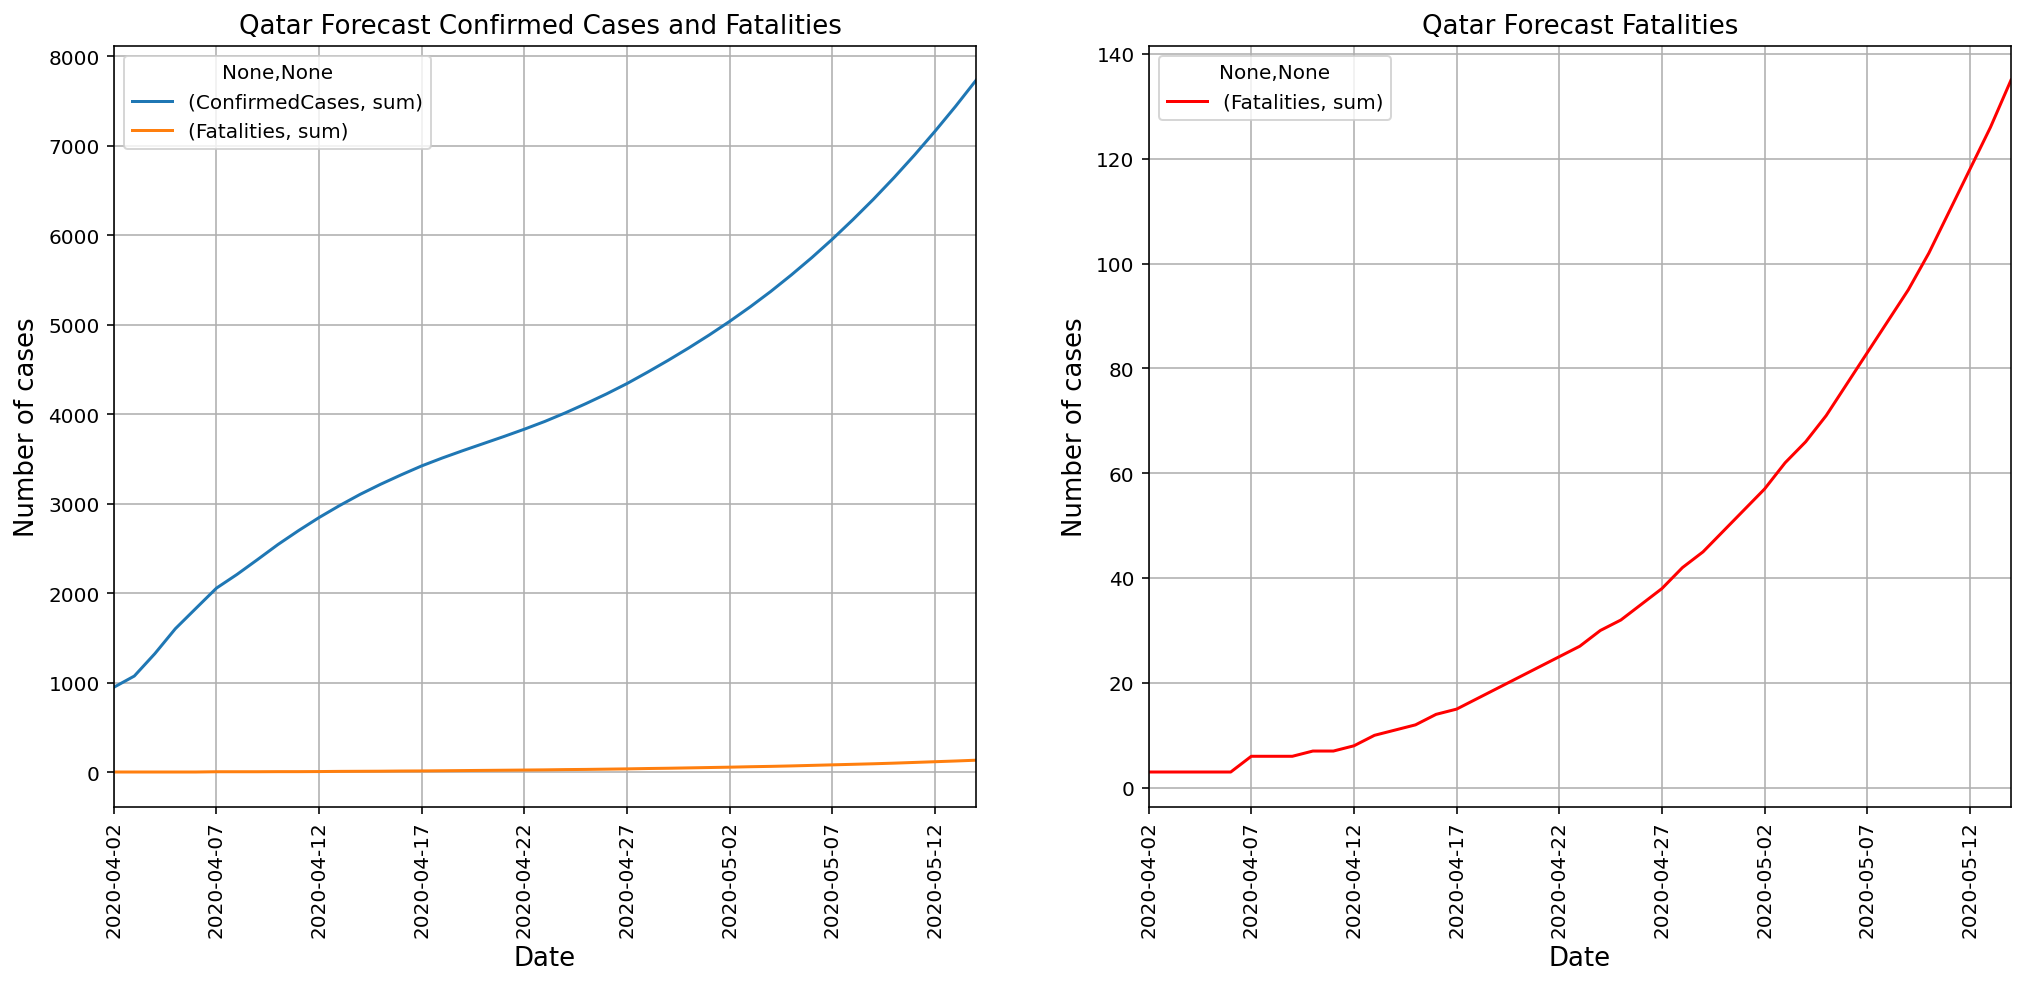

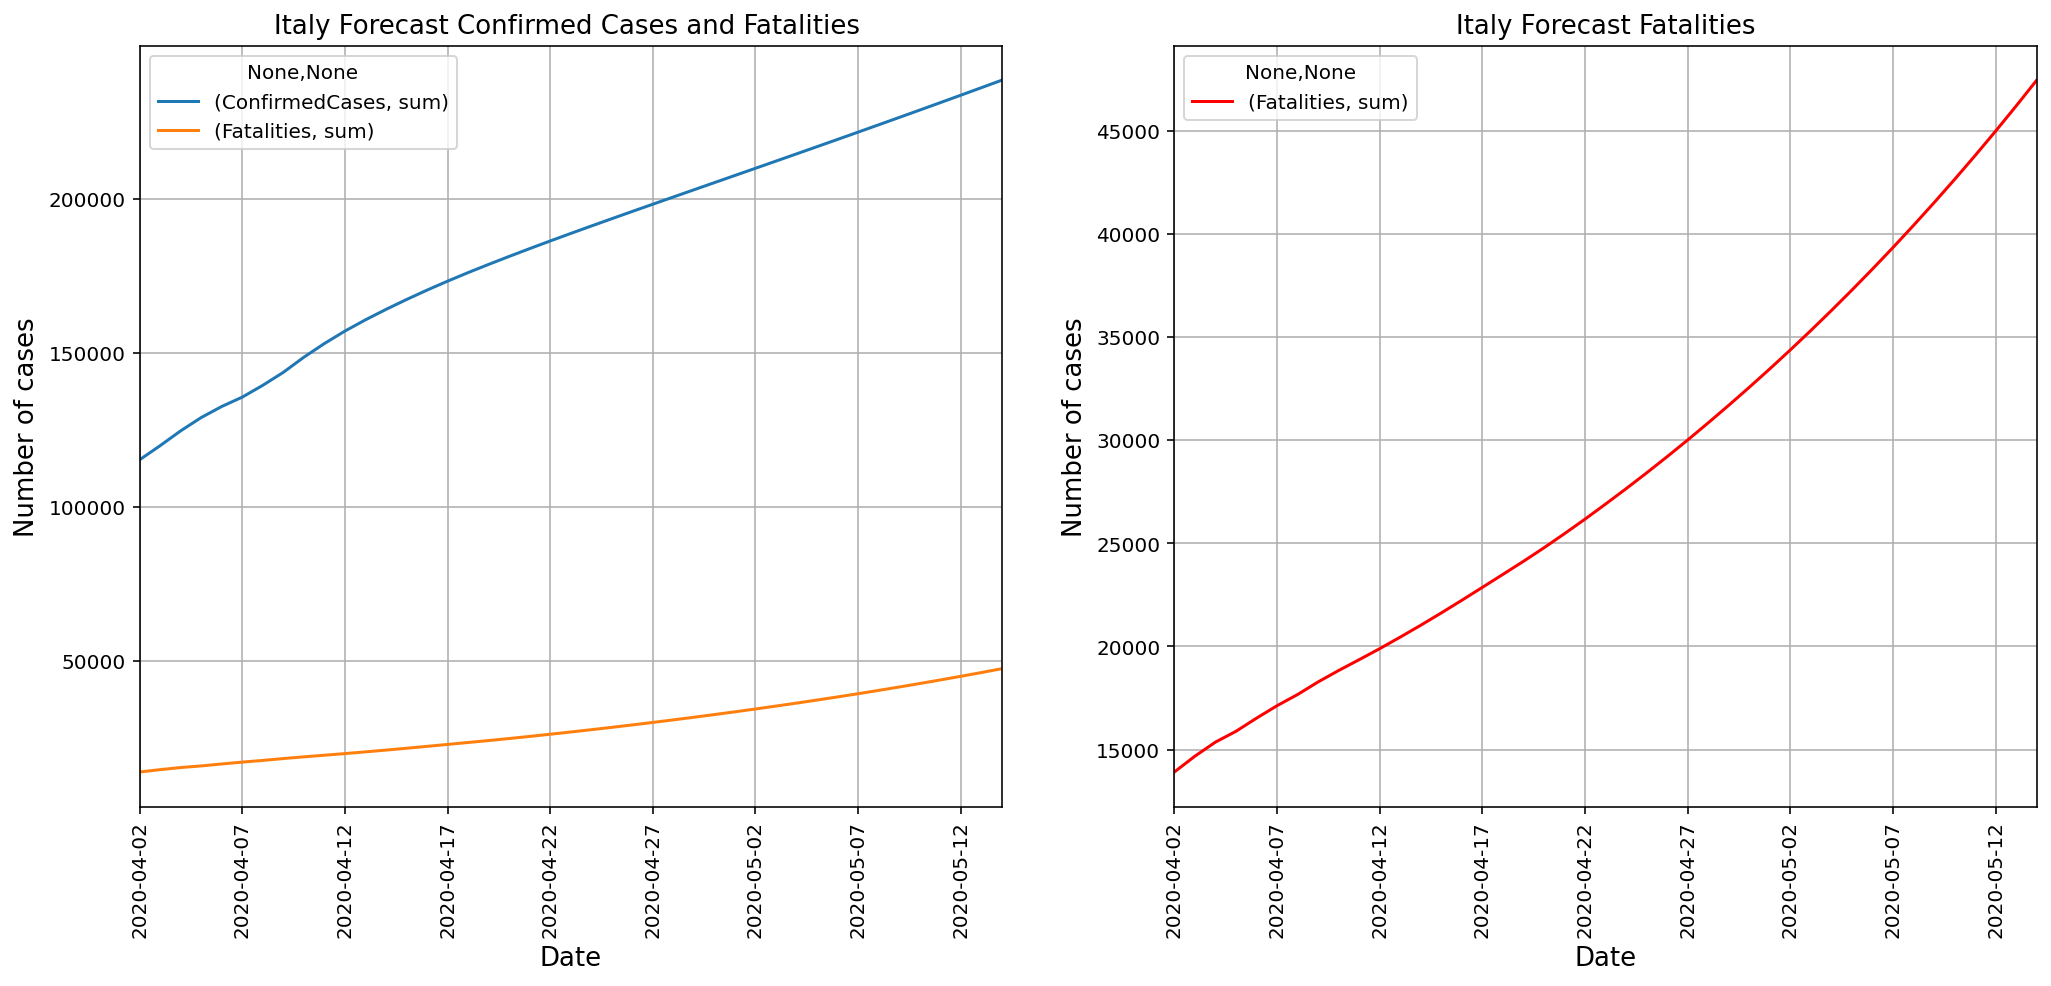

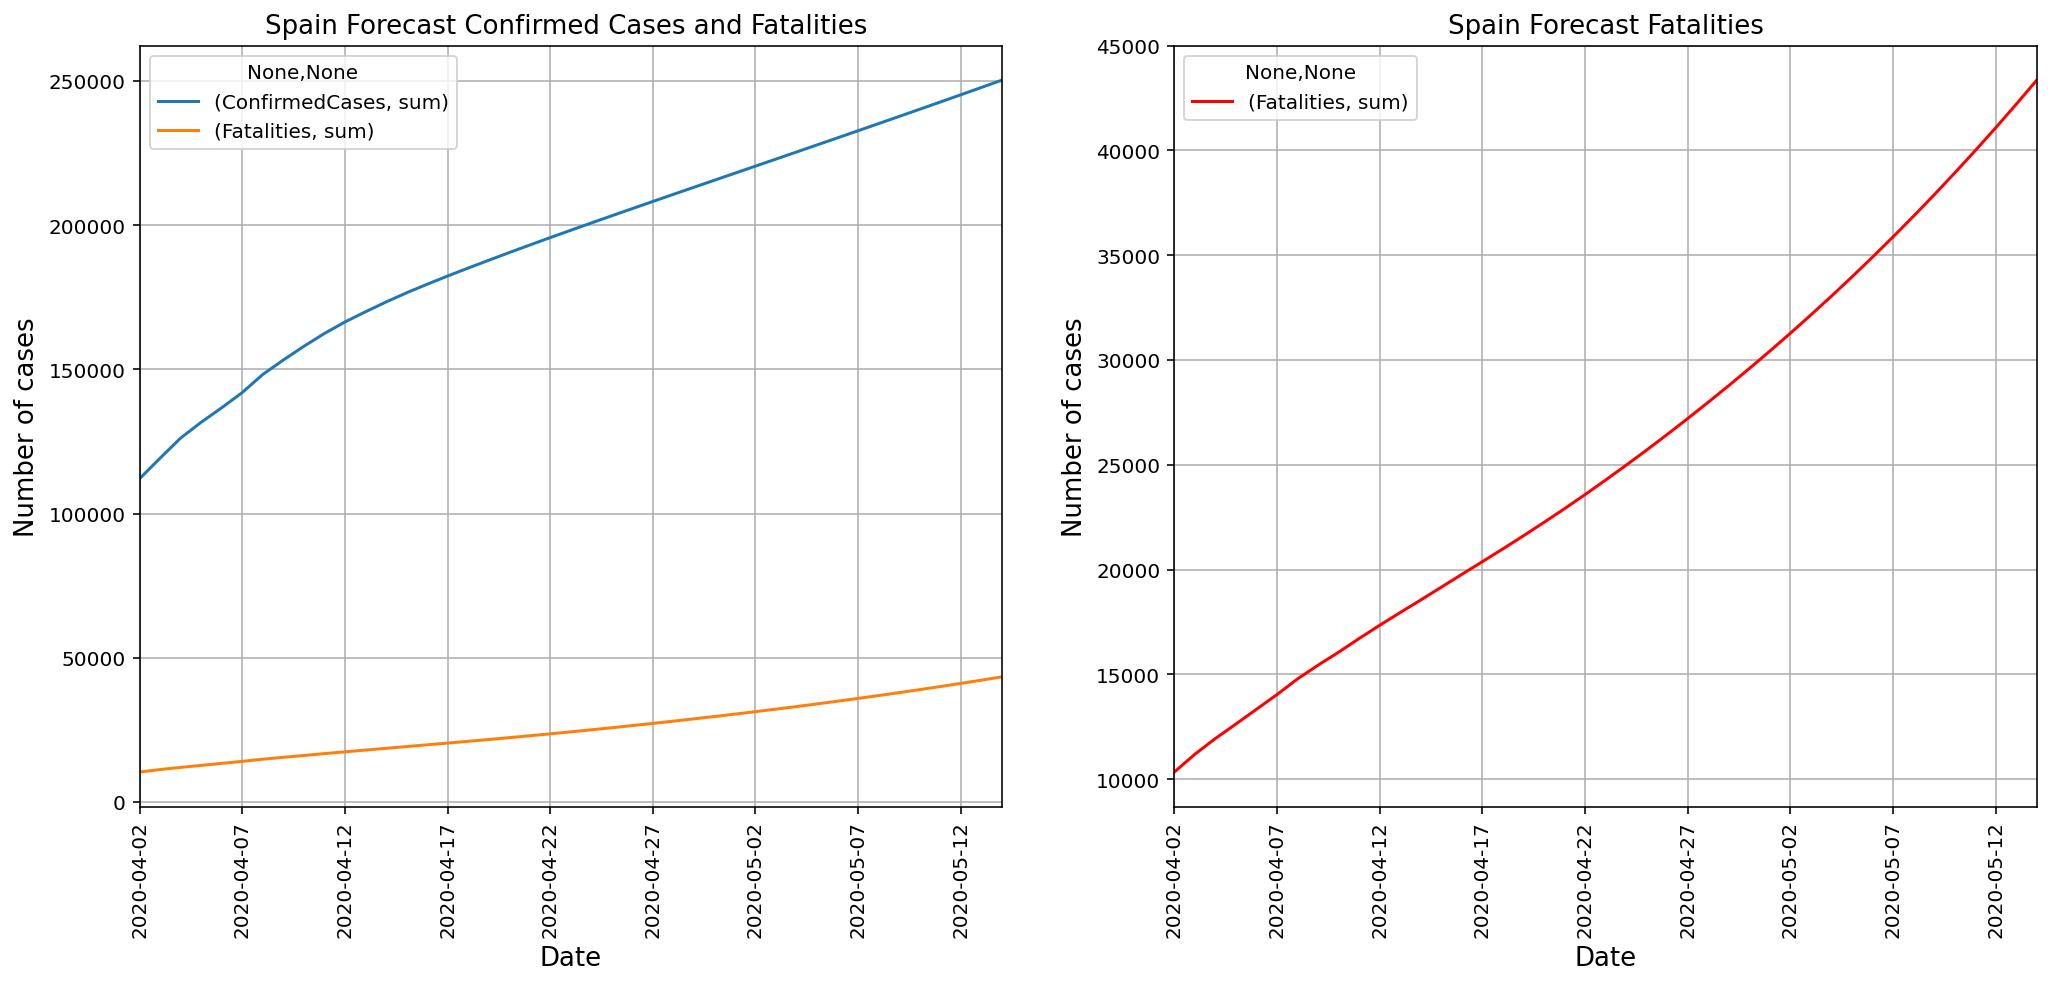

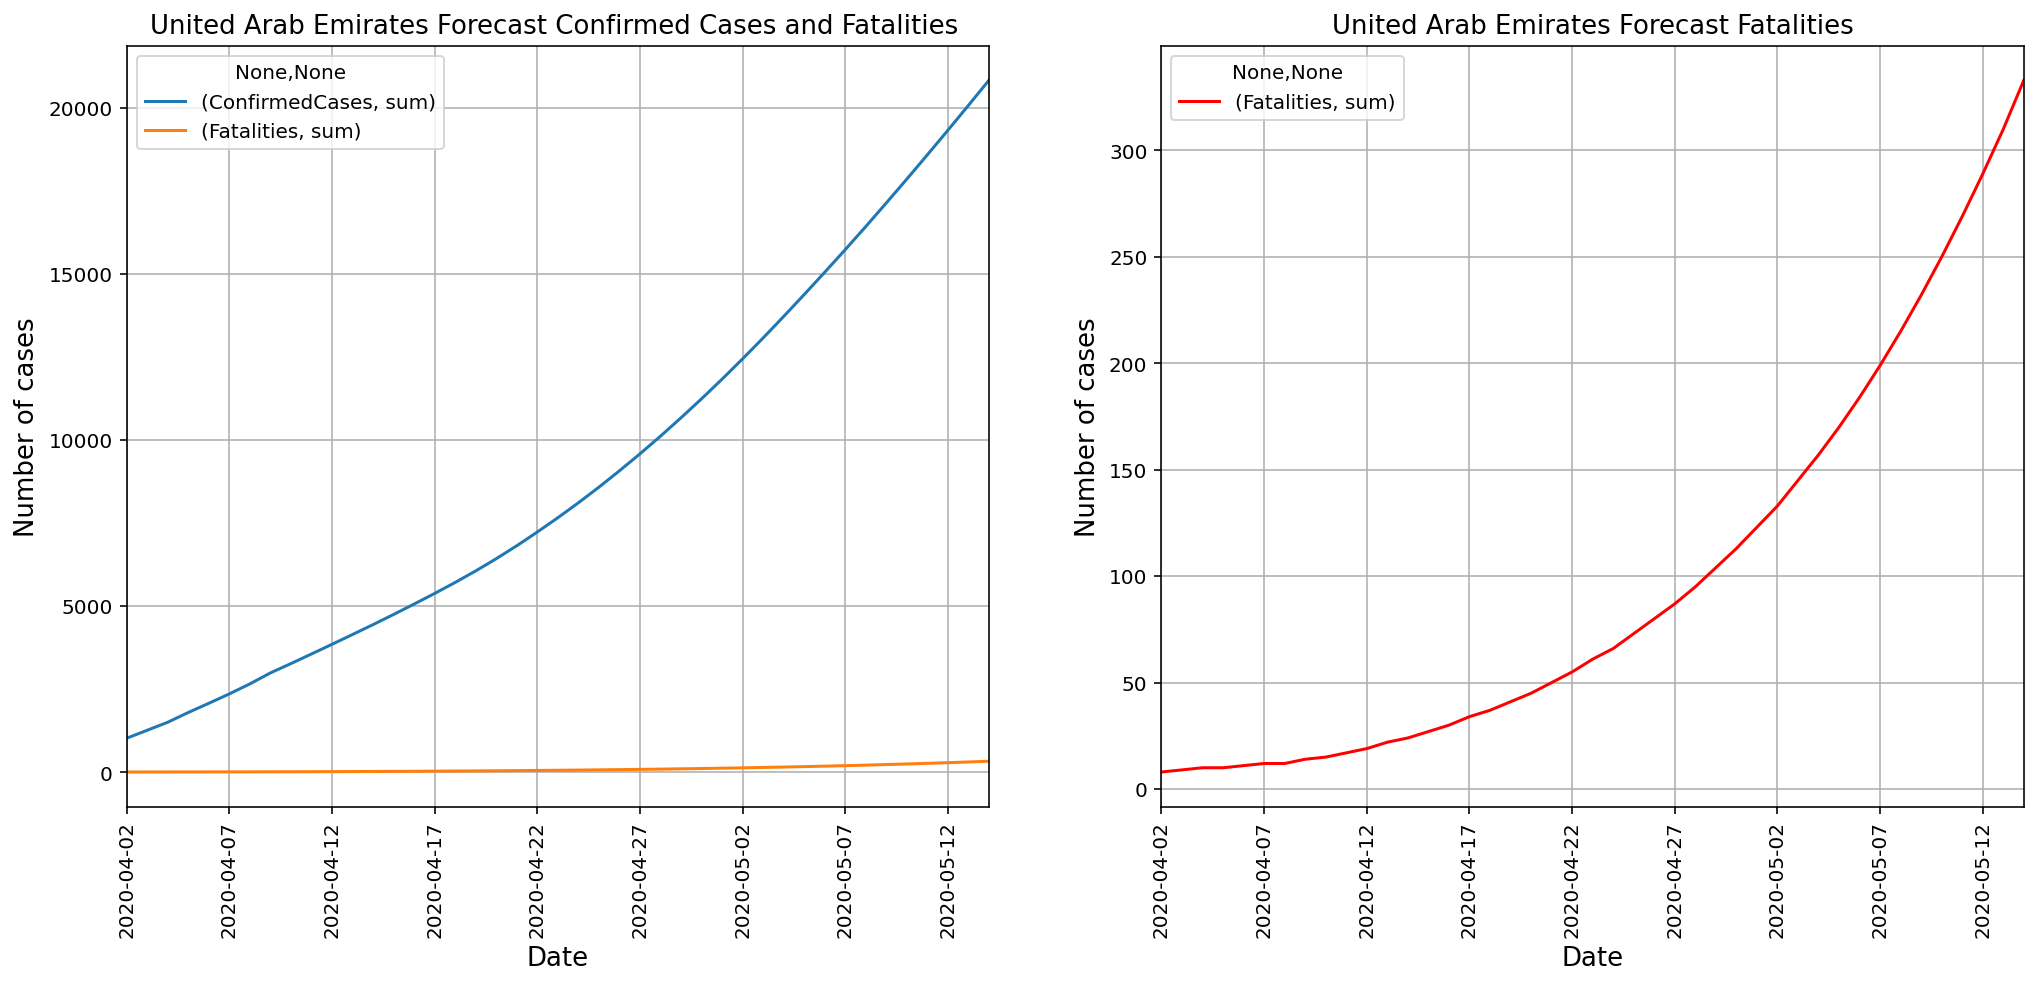

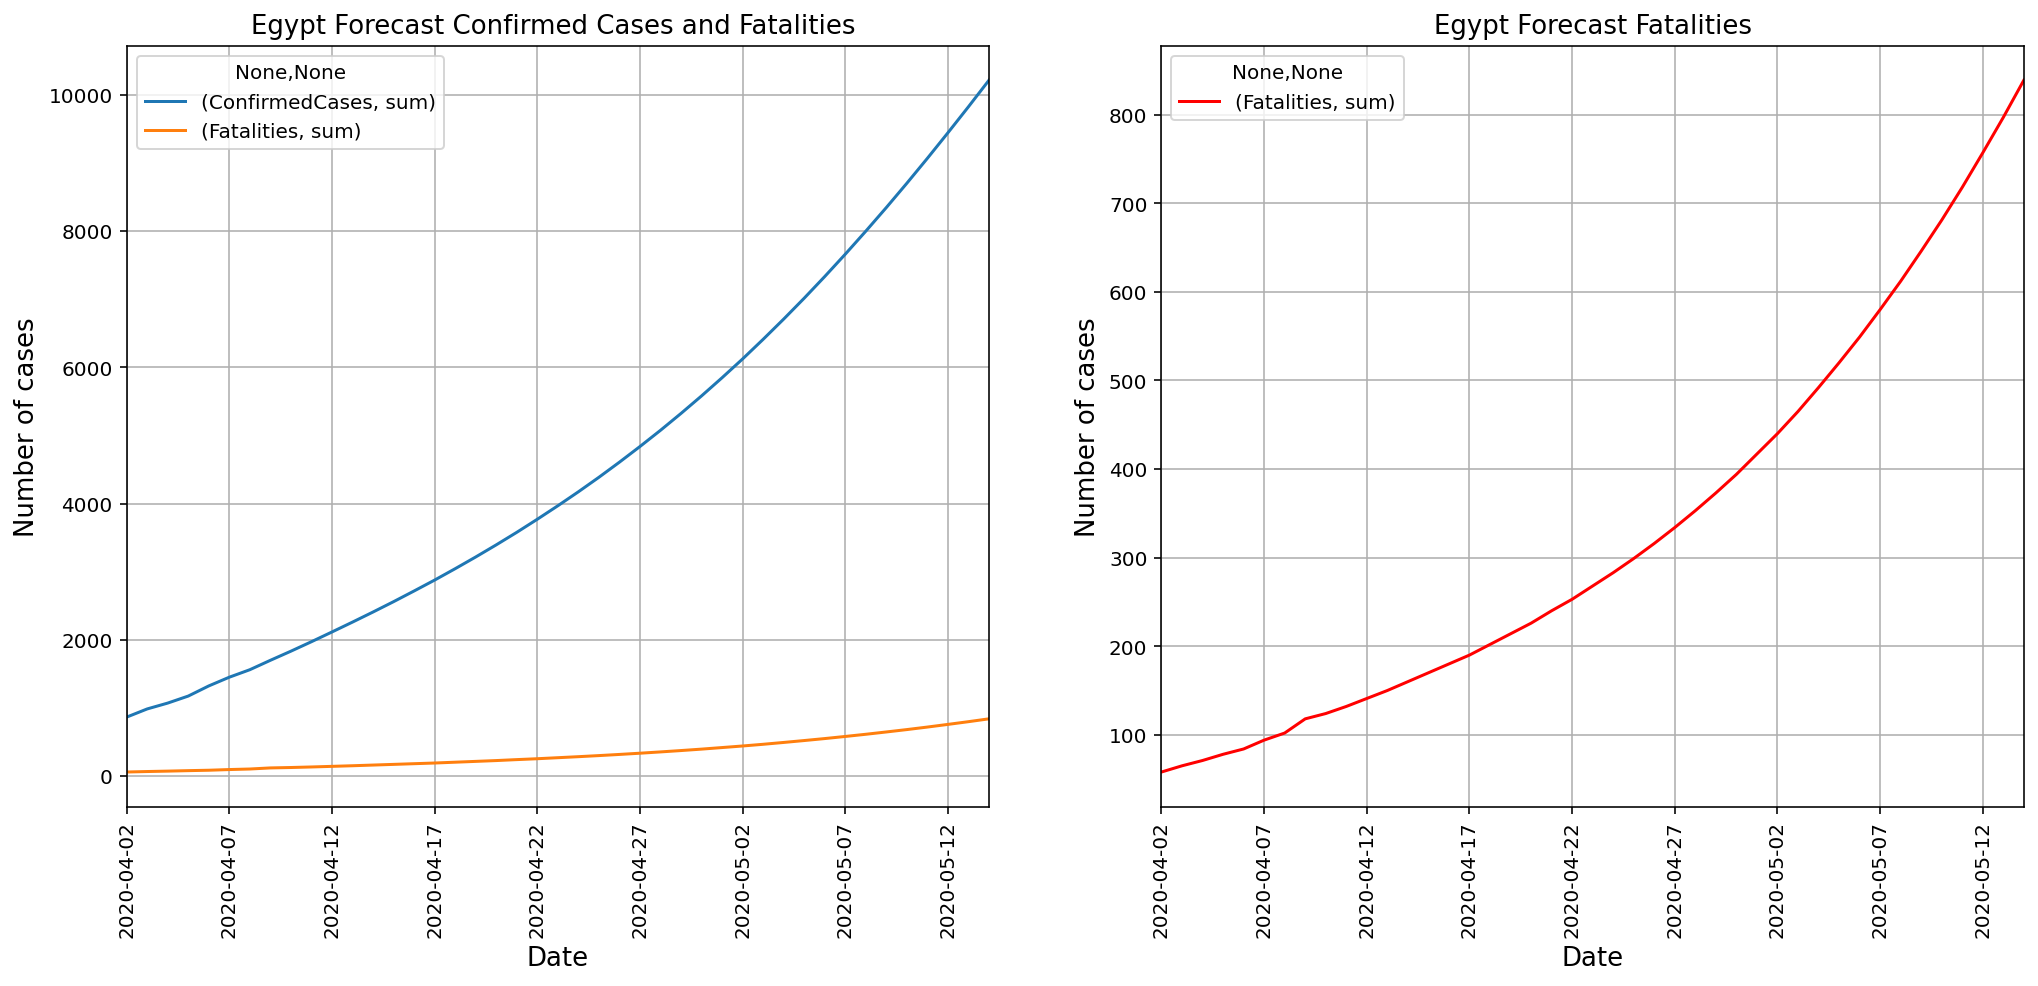

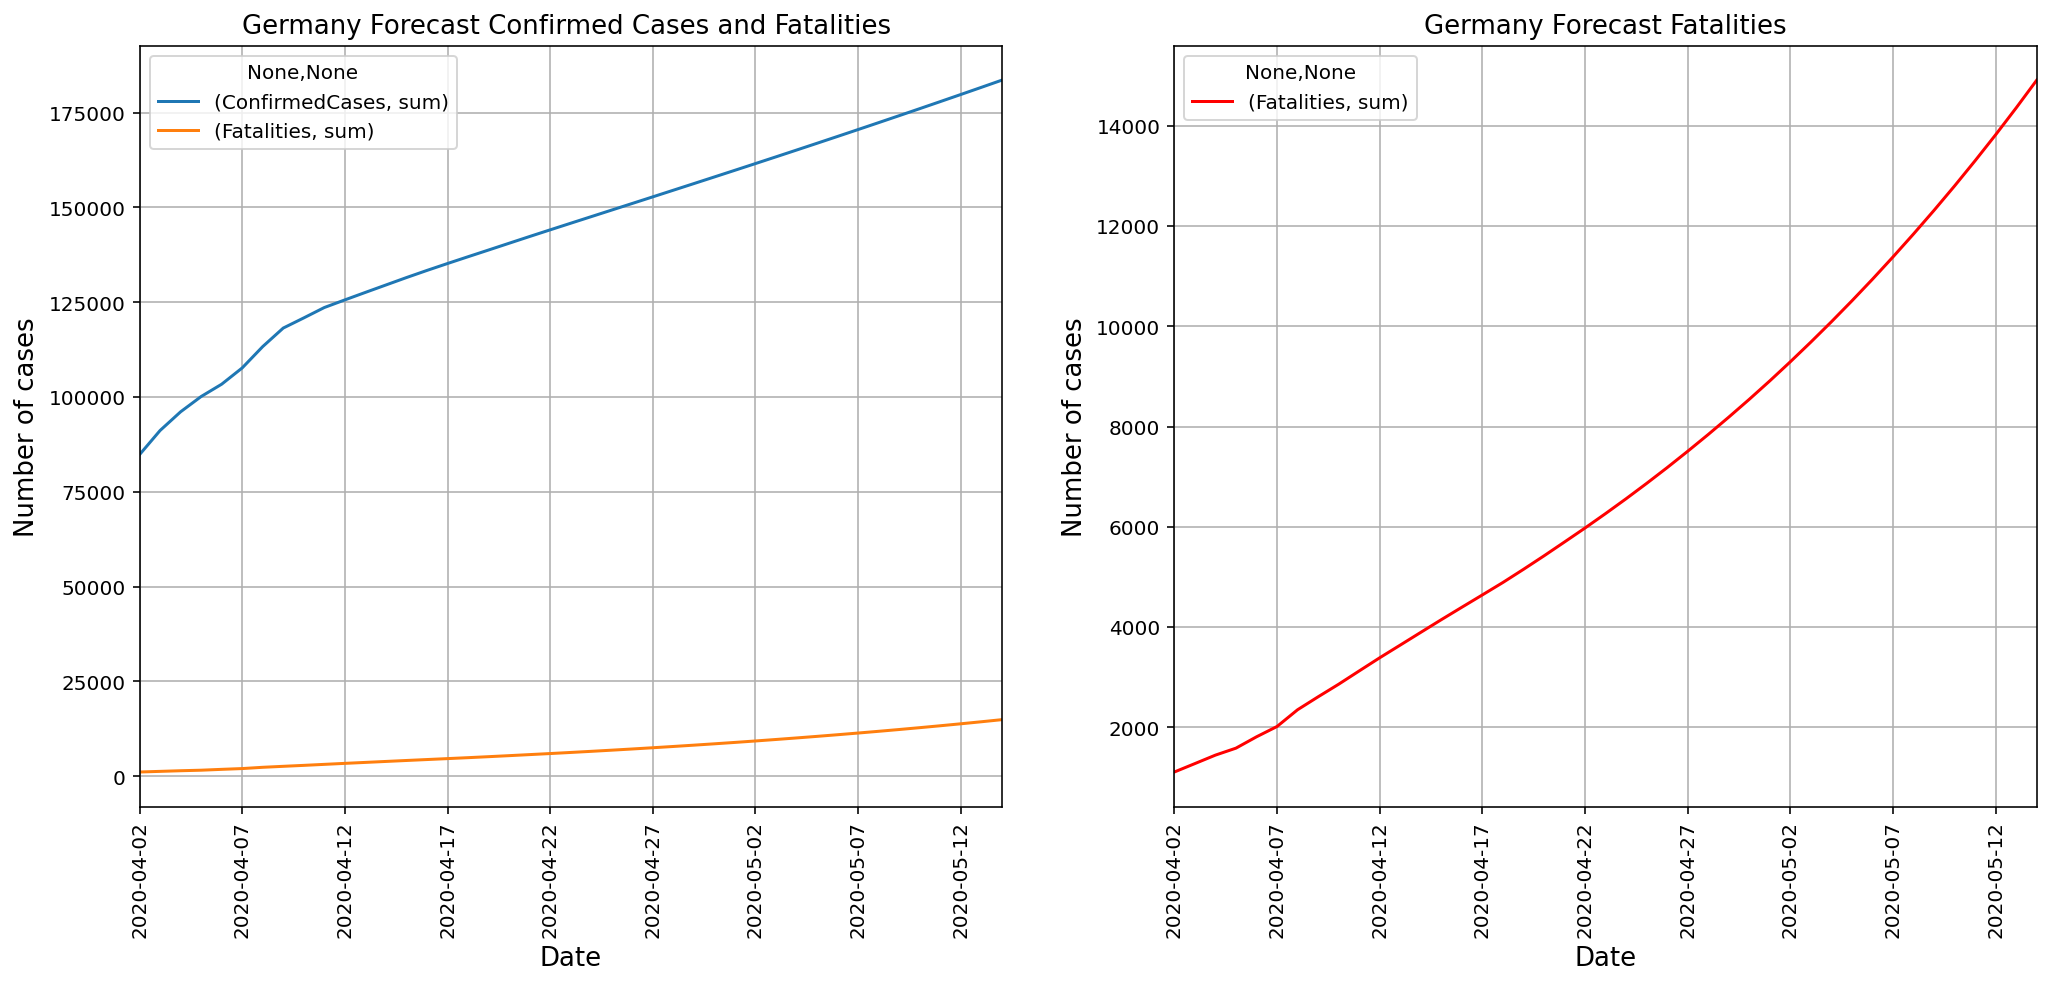

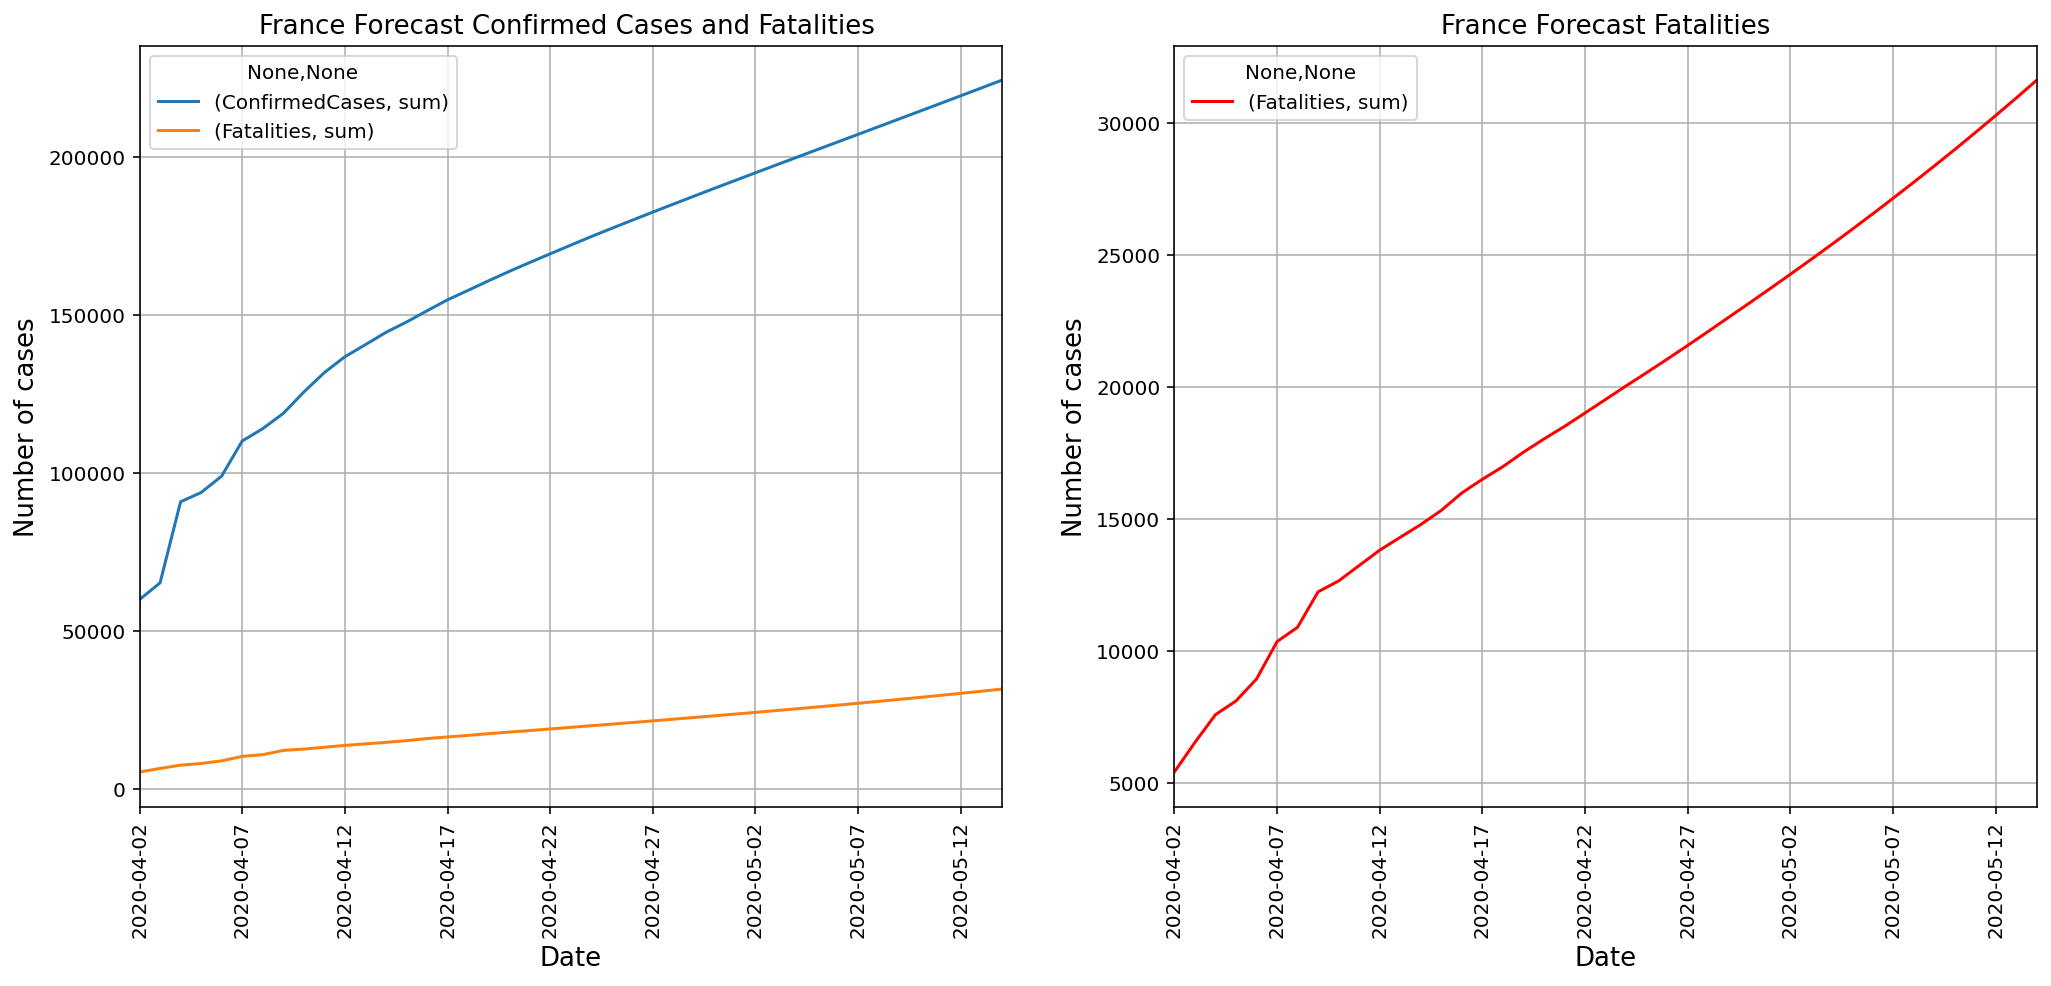

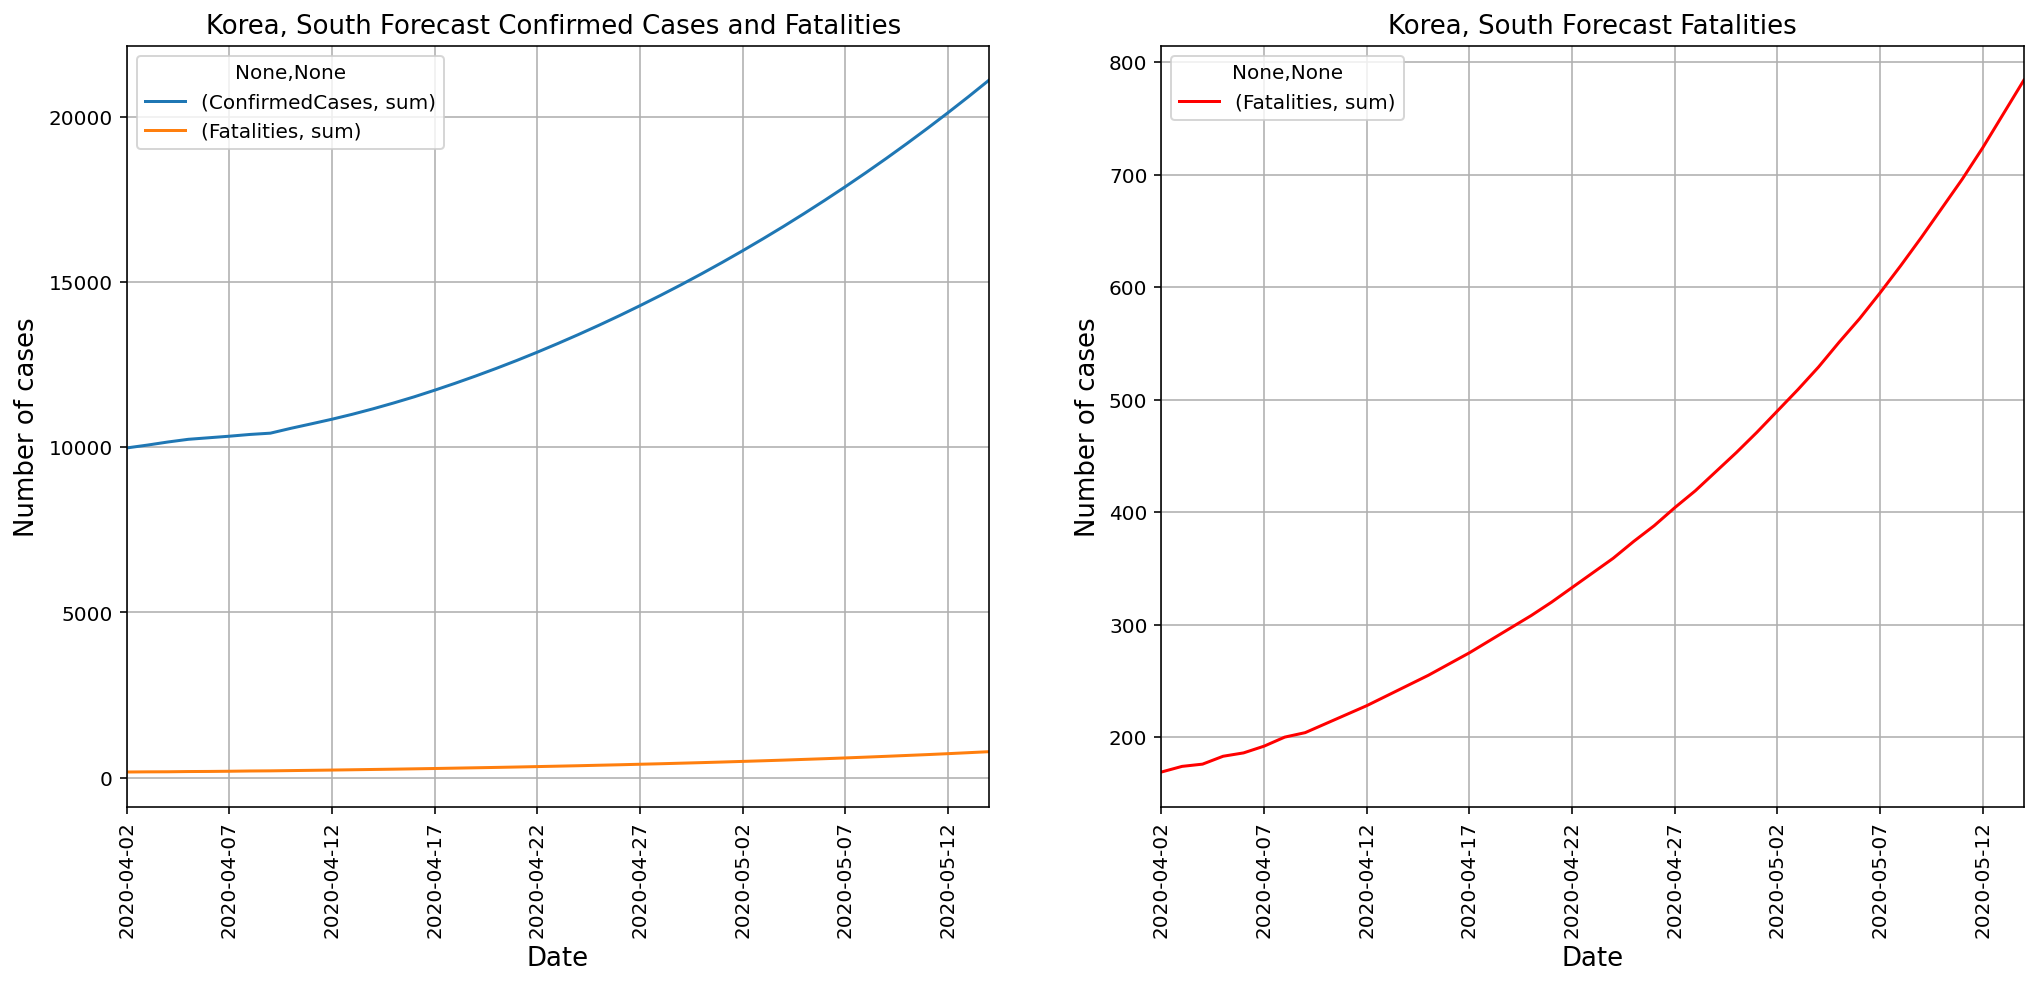

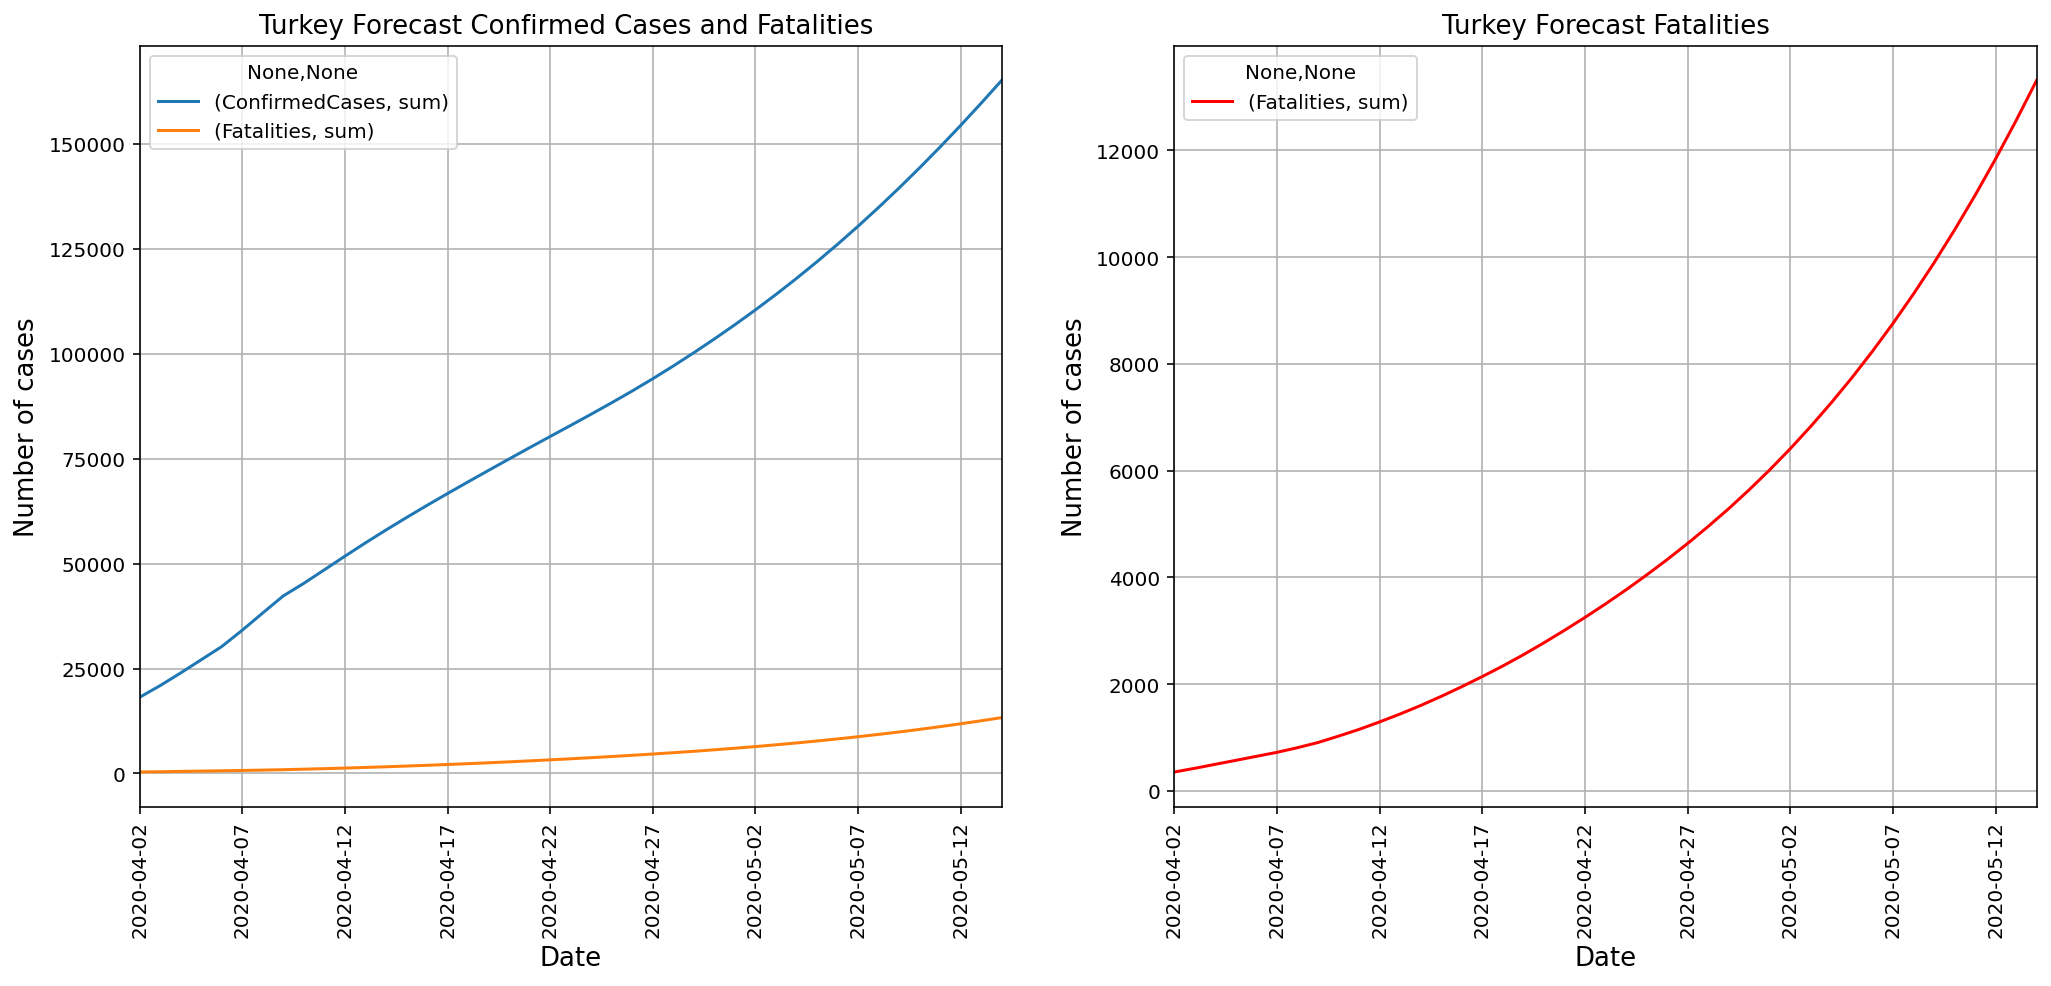

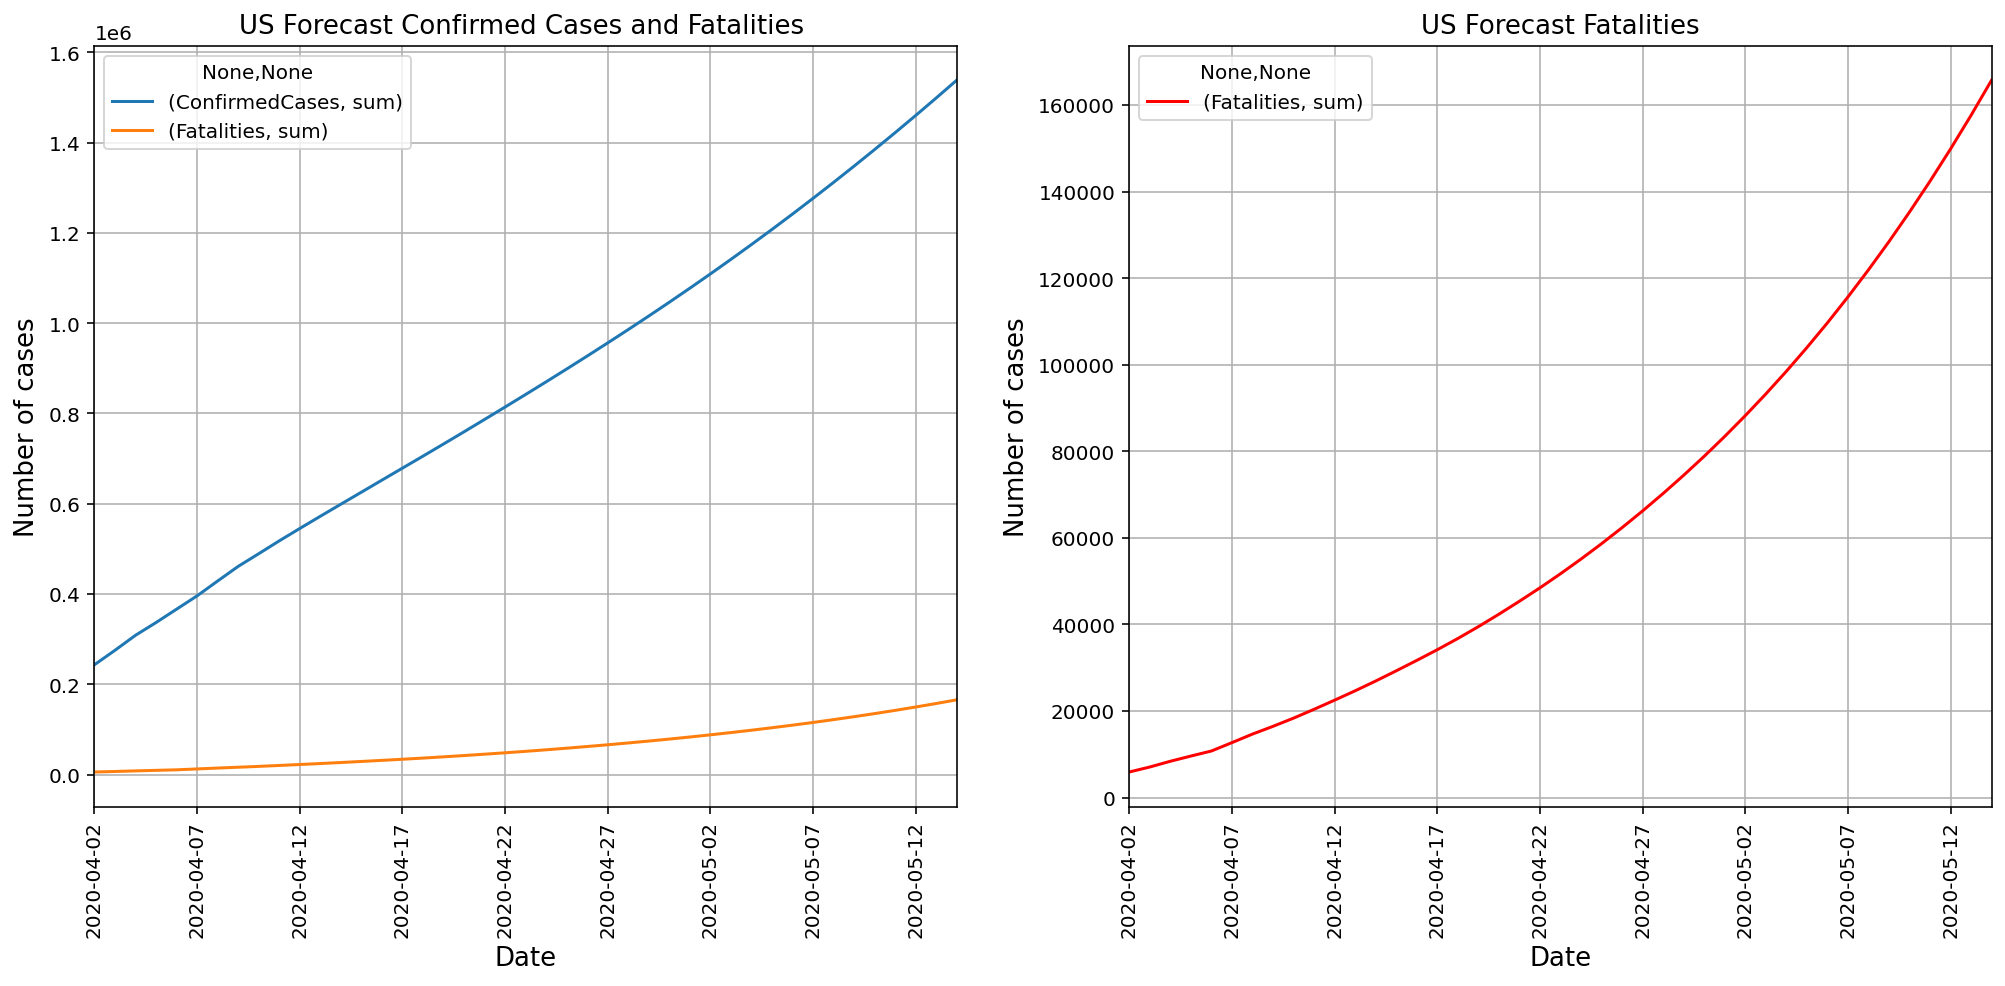

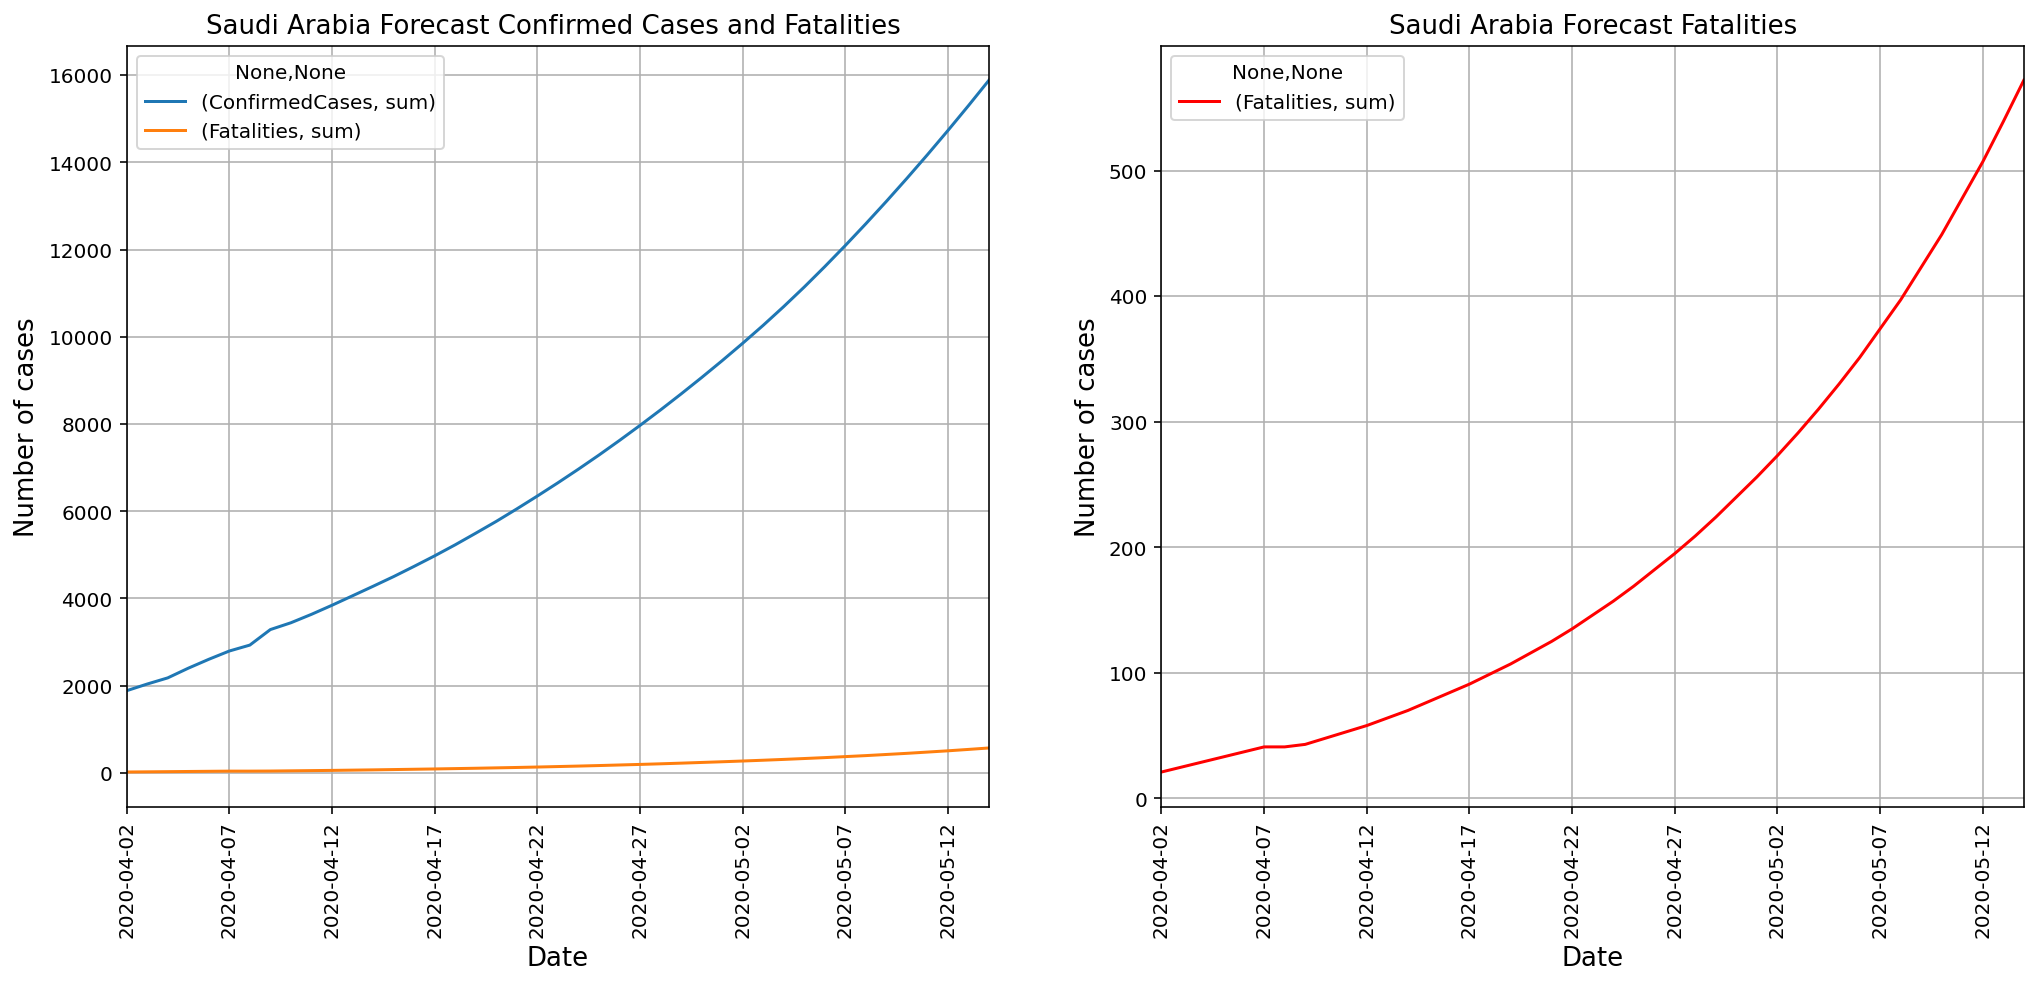

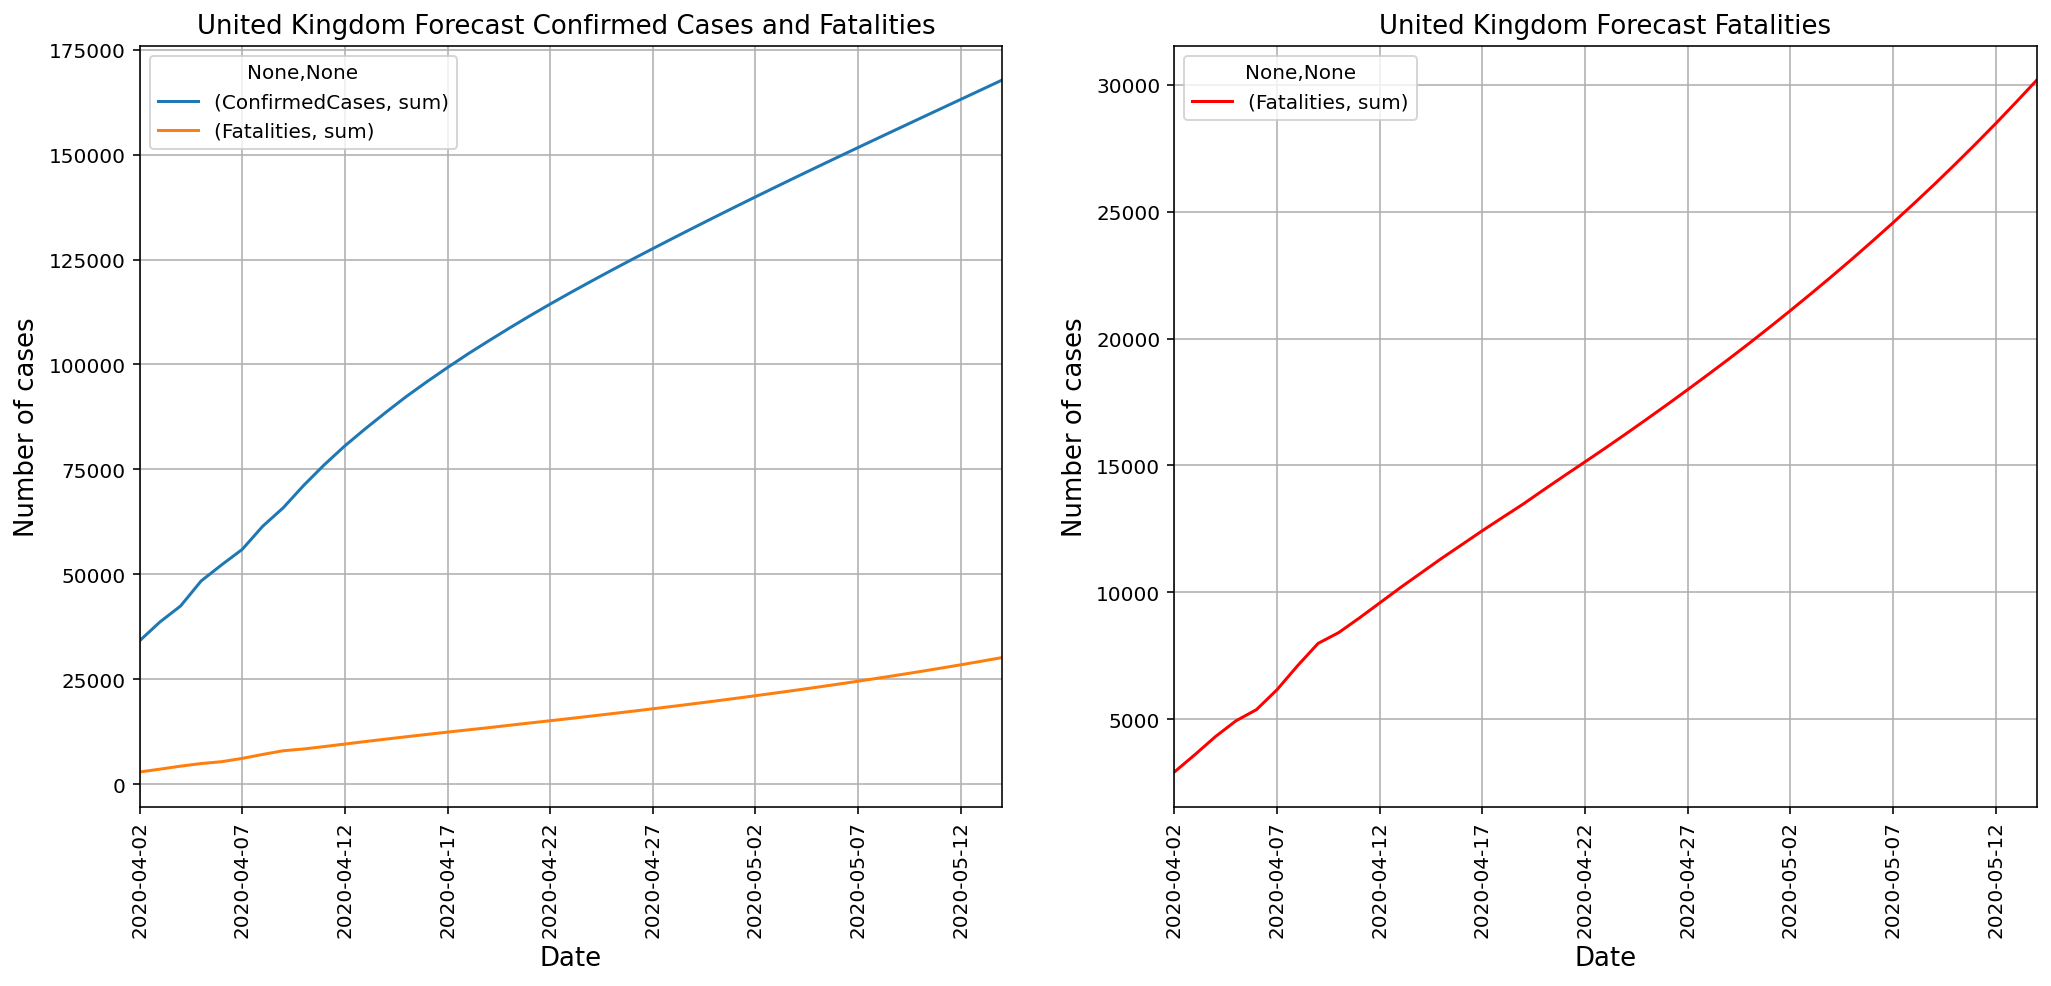

In [88]:
countrylist=['Qatar','Italy','Spain','United Arab Emirates','Egypt','Germany','France','Korea, South','Turkey','US','Saudi Arabia','United Kingdom']
for co in countrylist:
    countryplot(Predicted_data,co)
    #country='Italy'


In [93]:
def countryplottotal(train_df):
      
    confirmed_total = train_df.groupby(['Date']).agg({'ConfirmedCases':['sum']})
    fatalities_total = train_df.groupby(['Date']).agg({'Fatalities':['sum']})
    total = confirmed_total.join(fatalities_total)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
    total.plot(ax=ax1)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    ax1.set_title("World Wide Forecast Confirmed Cases and Fatalities ", size=13,)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)
    #ax1.set_xticklabels("Date",rotation= 90)
    #plt.xticks(rotation=90)
    ax1.grid()
    fatalities_total.plot(ax=ax2, color='red')
    plt.grid()
    ax2.set_title("World Wide Forecast Fatalities", size=13)
    ax2.set_ylabel("Number of cases", size=13)
    ax2.set_xlabel("Date", size=13)
    plt.xticks(rotation=90)
    plt.show()

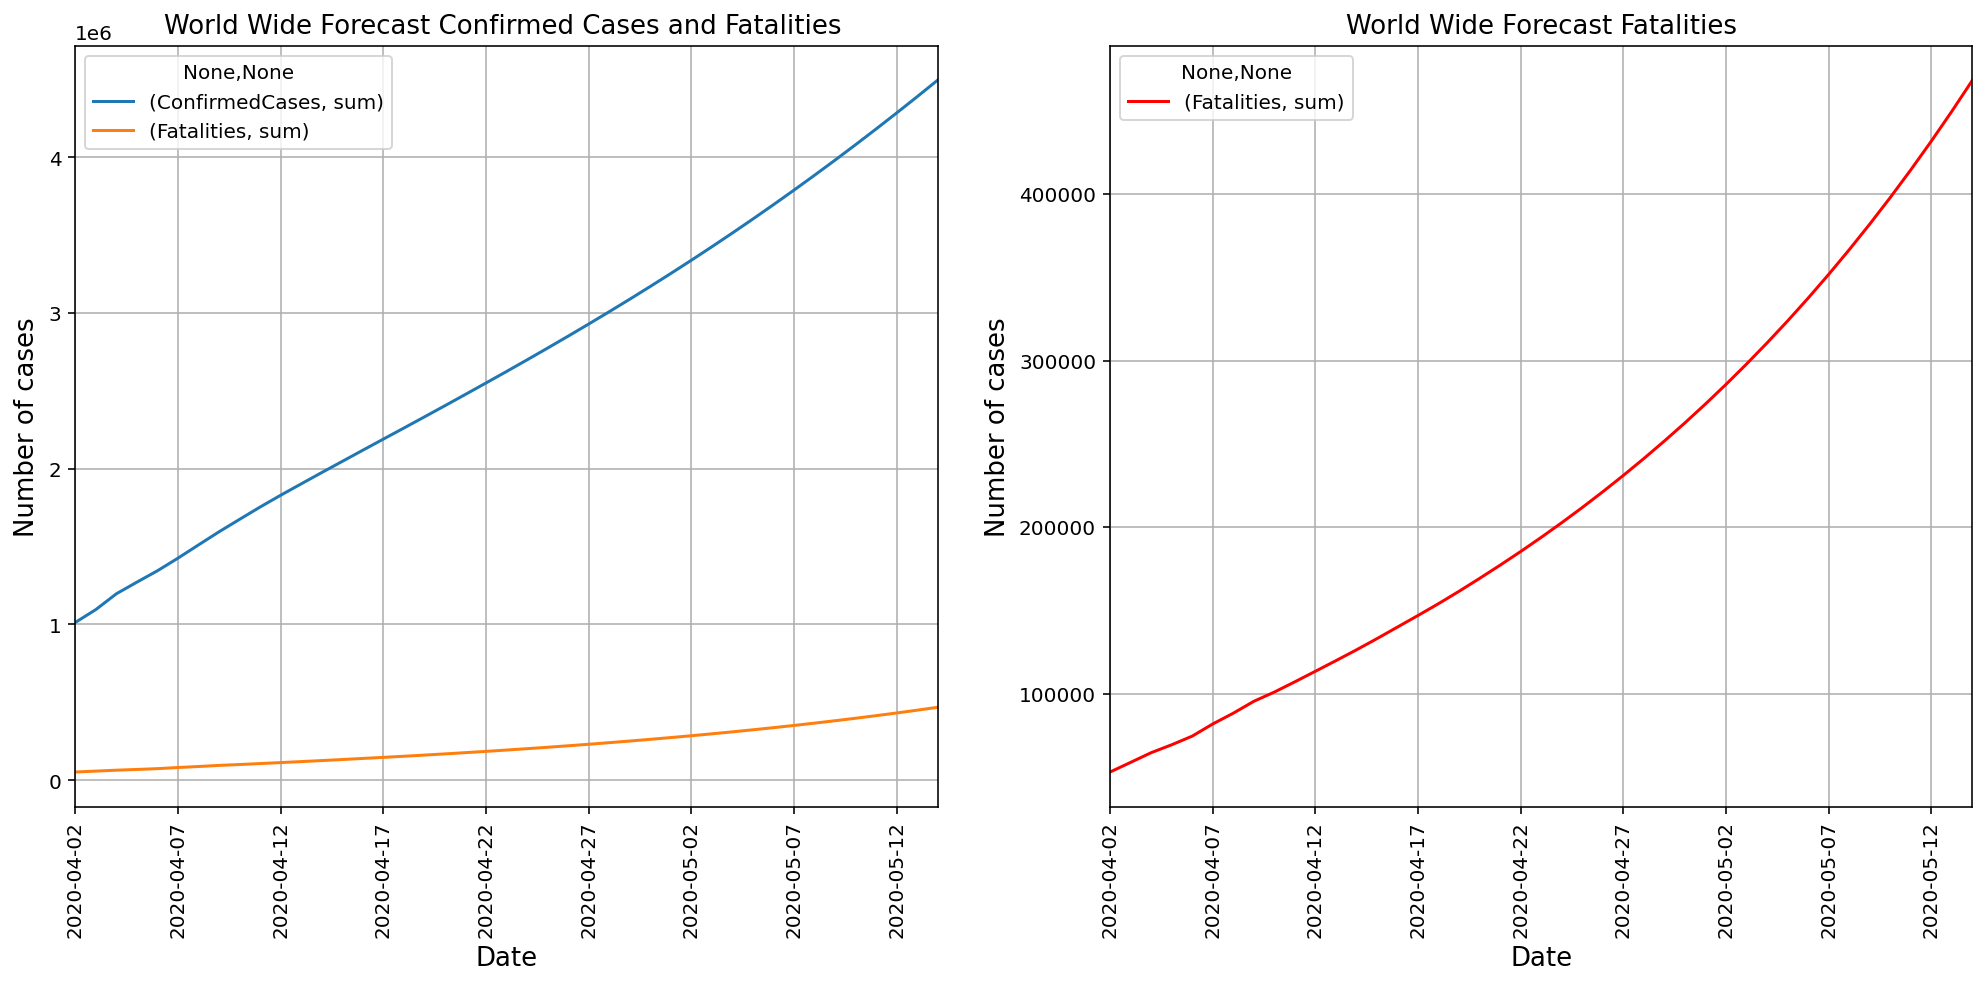

In [94]:
countryplottotal(Predicted_data)

In [103]:
def countryplot_trend(train_df,country):
    
    confirmed_total = train_df[train_df['Country_Region']==country_dict[country]].groupby(['Date']).agg({'trend_ConfirmedCases':['sum']})
    fatalities_total = train_df[train_df['Country_Region']==country_dict[country]].groupby(['Date']).agg({'trend_Fatalities':['sum']})
    
    n_bins = 20
    fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)

    # We can set the number of bins with the `bins` kwarg
    axs[0].hist(confirmed_total, bins=n_bins)
    axs[1].hist(fatalities_total, bins=n_bins)
''' total = confirmed_total.join(fatalities_total)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,7))
    total.hist(ax=ax1)
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=90)
    ax1.set_title(country + " Forecast Confirmed Cases and Fatalities ", size=13,)
    ax1.set_ylabel("Number of cases", size=13)
    ax1.set_xlabel("Date", size=13)
    #ax1.set_xticklabels("Date",rotation= 90)
    #plt.xticks(rotation=90)
    ax1.grid()
    fatalities_total.plot(ax=ax2, color='red')
    plt.grid()
    ax2.set_title(country+" Forecast Fatalities", size=13)
    ax2.set_ylabel("Number of cases", size=13)
    ax2.set_xlabel("Date", size=13)
    plt.xticks(rotation=90)
    plt.show()'''
    



IndentationError: unexpected indent (<ipython-input-103-0171a8bf6982>, line 23)

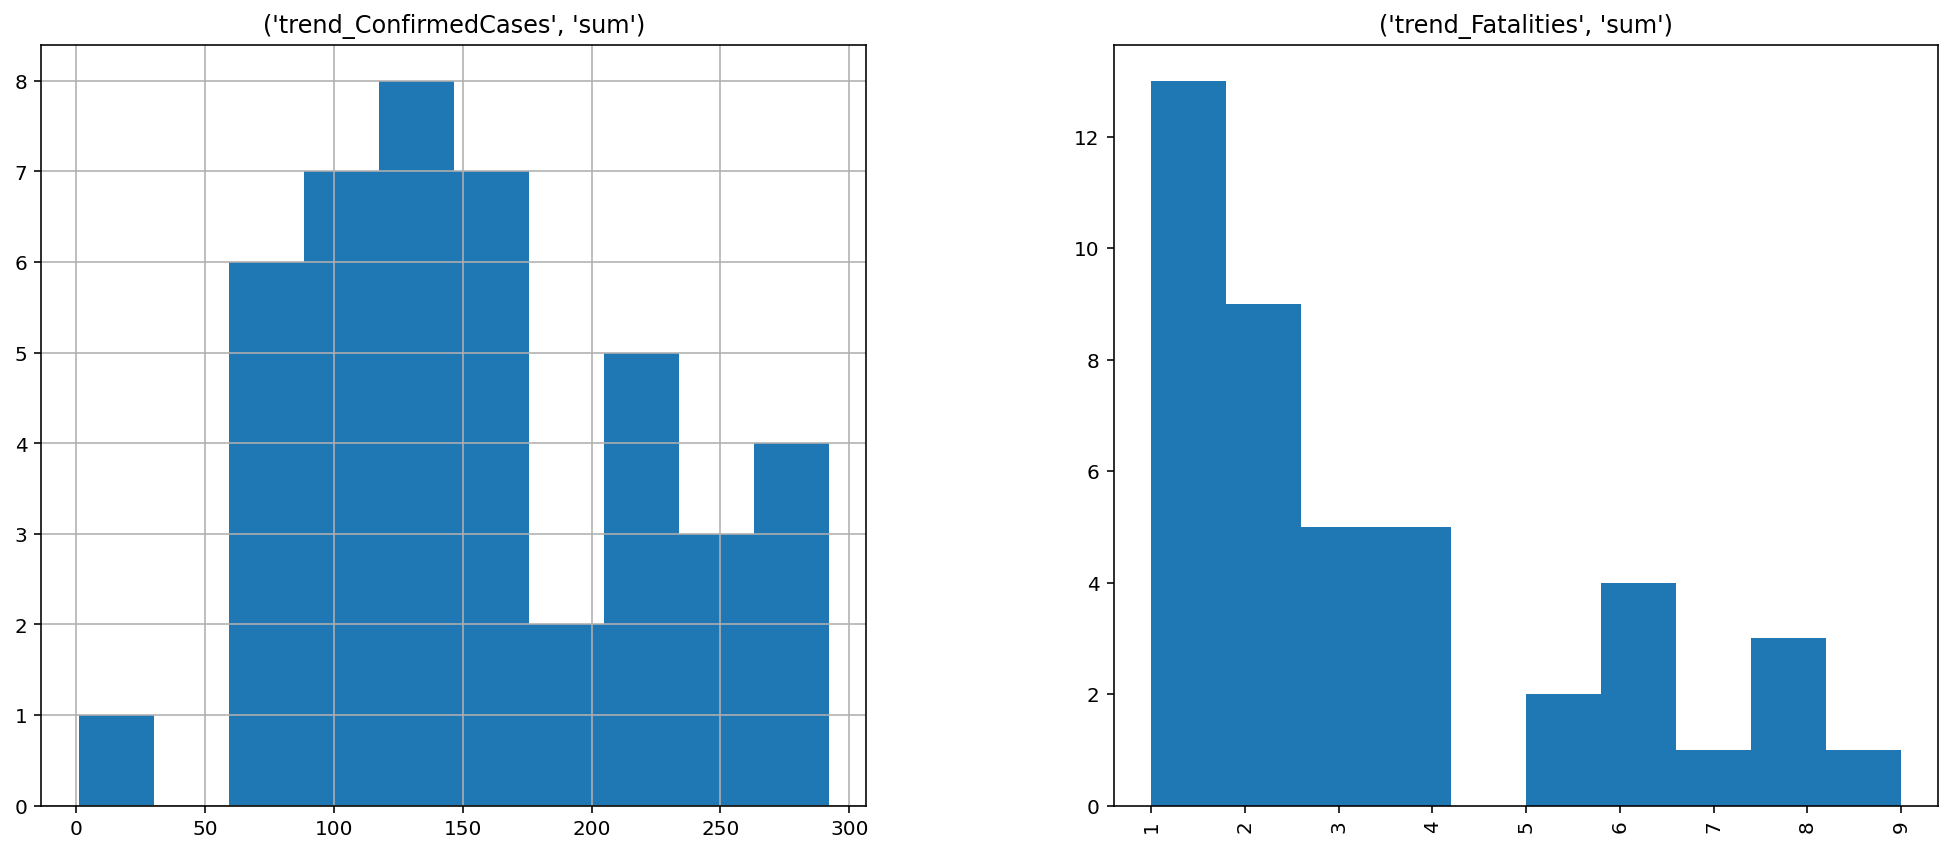

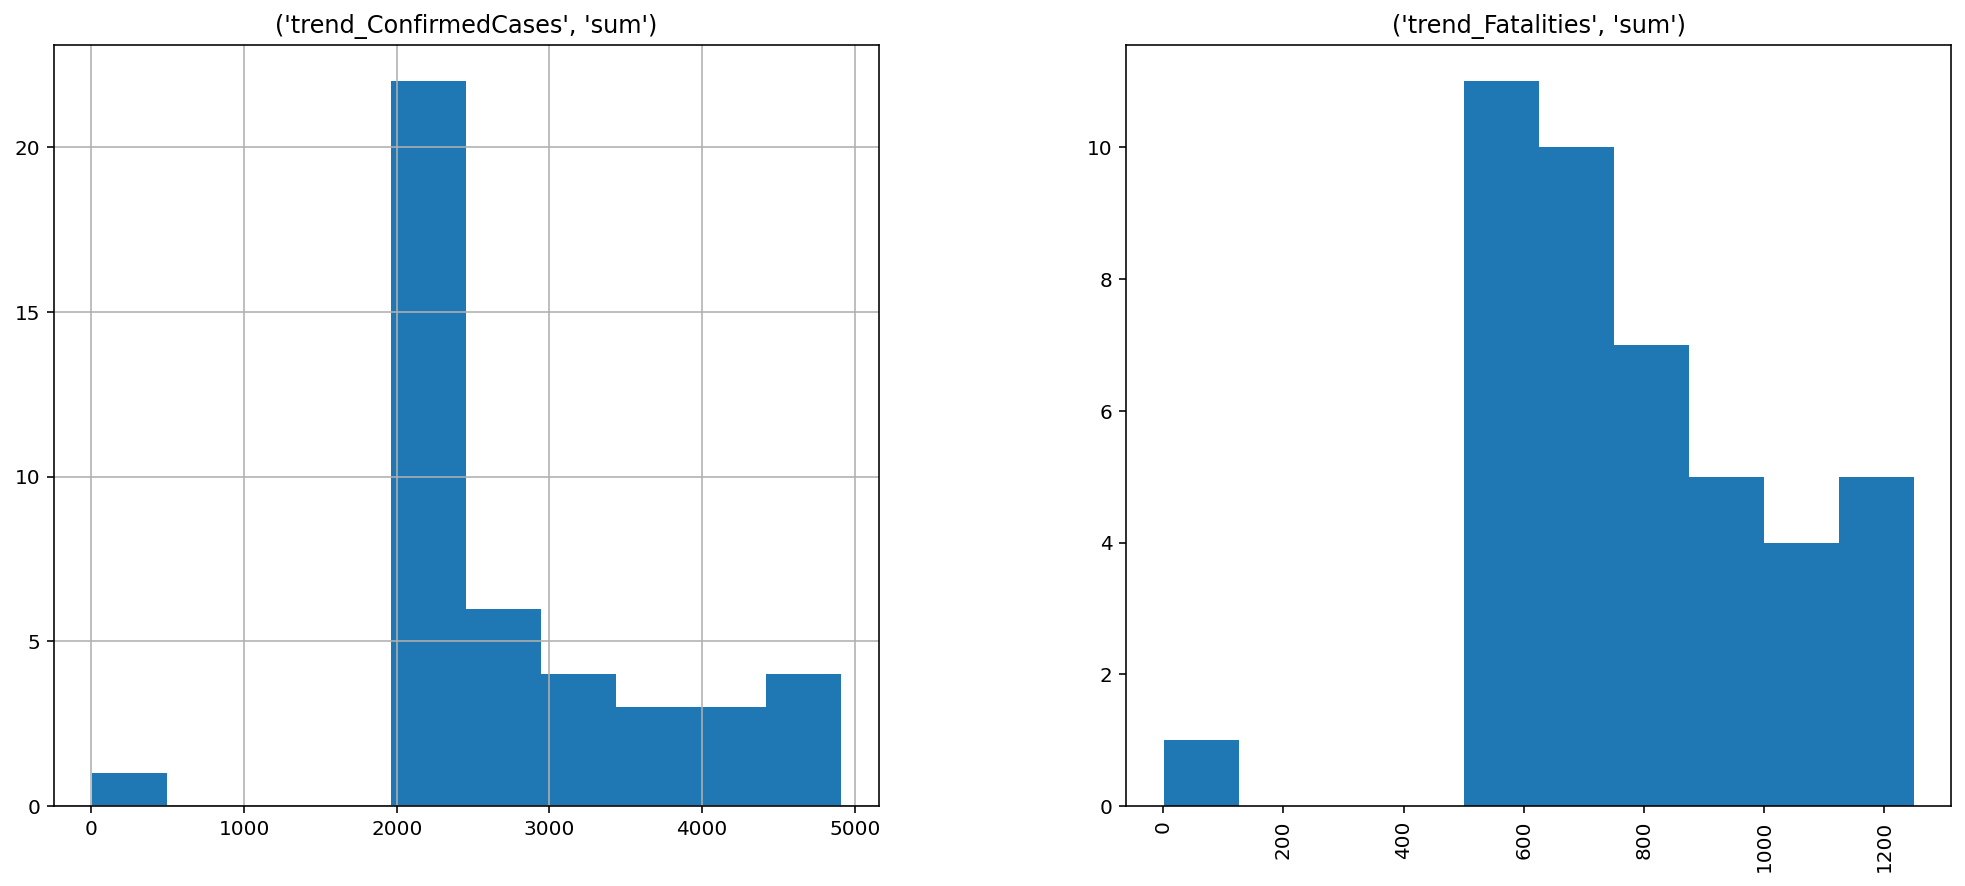

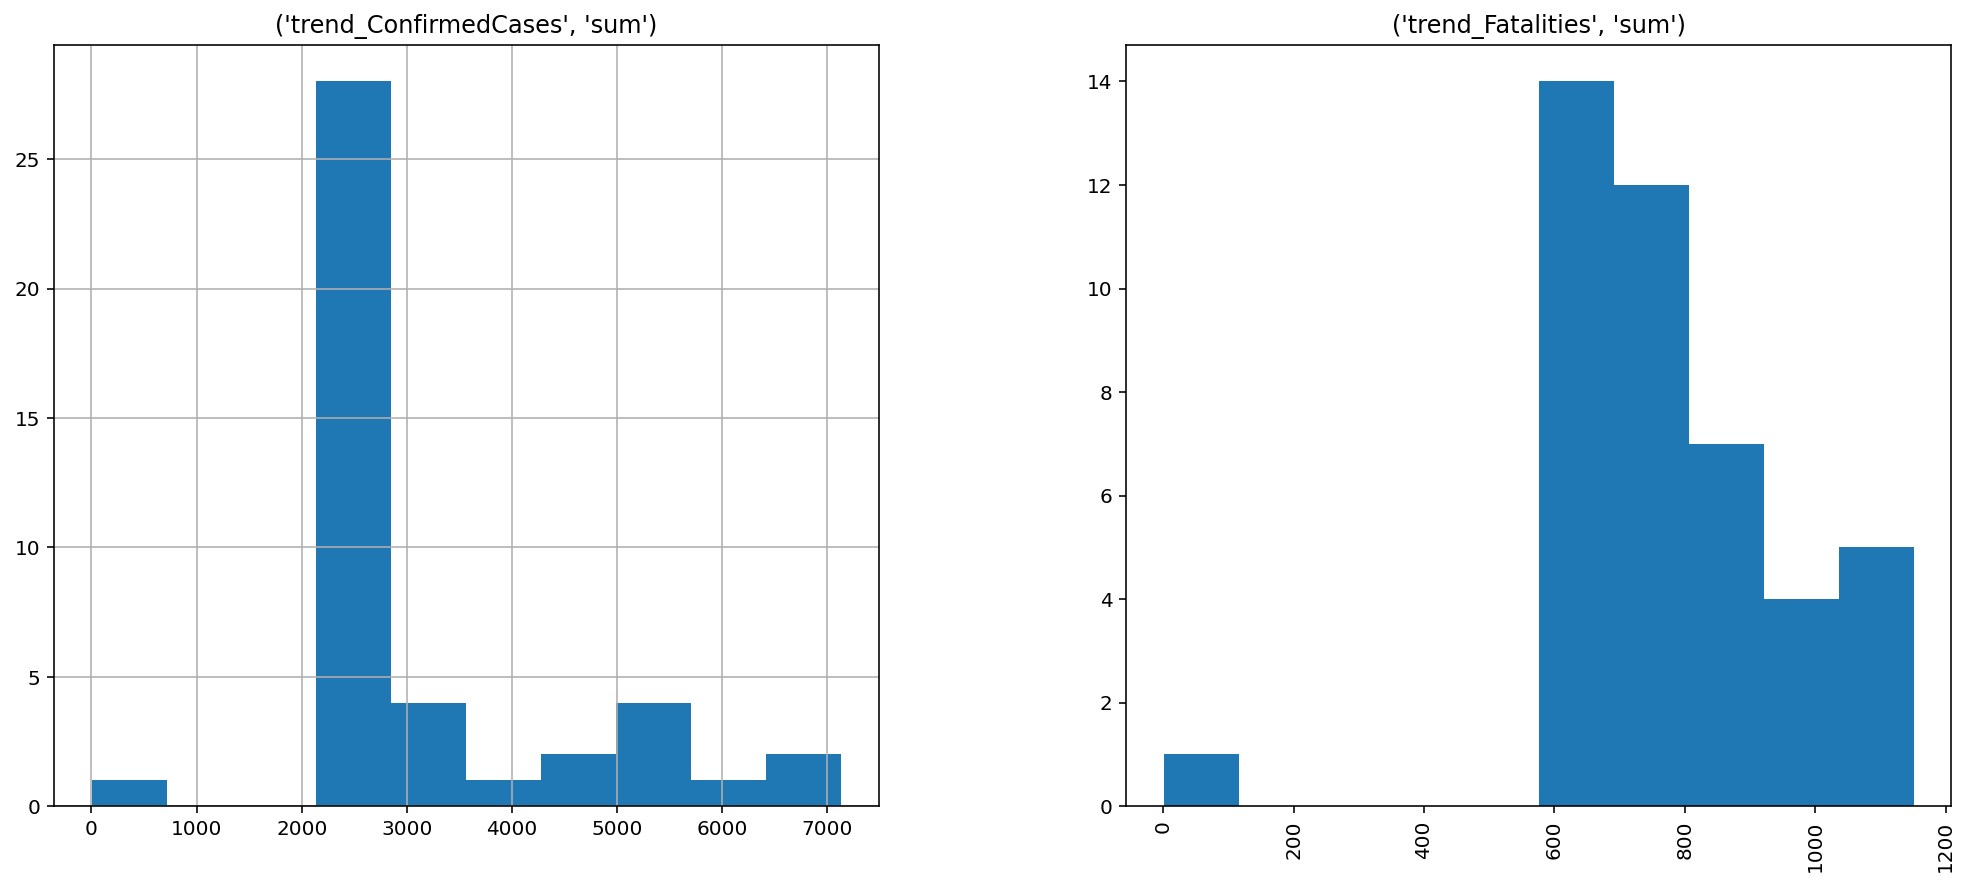

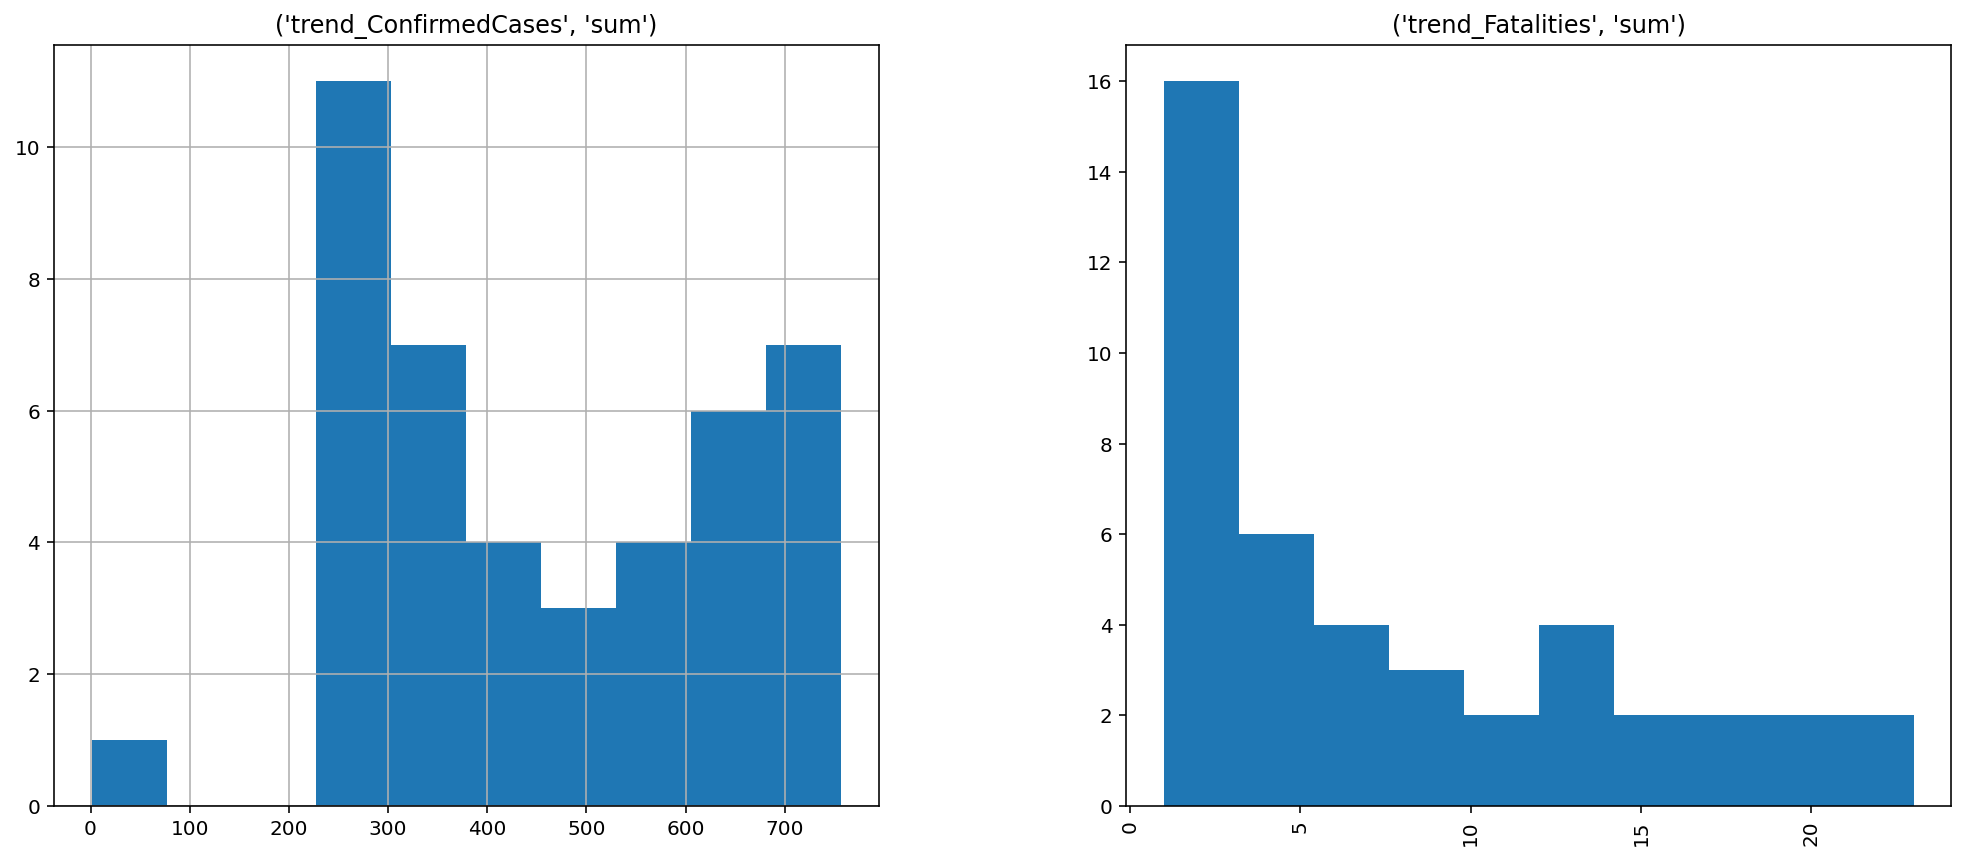

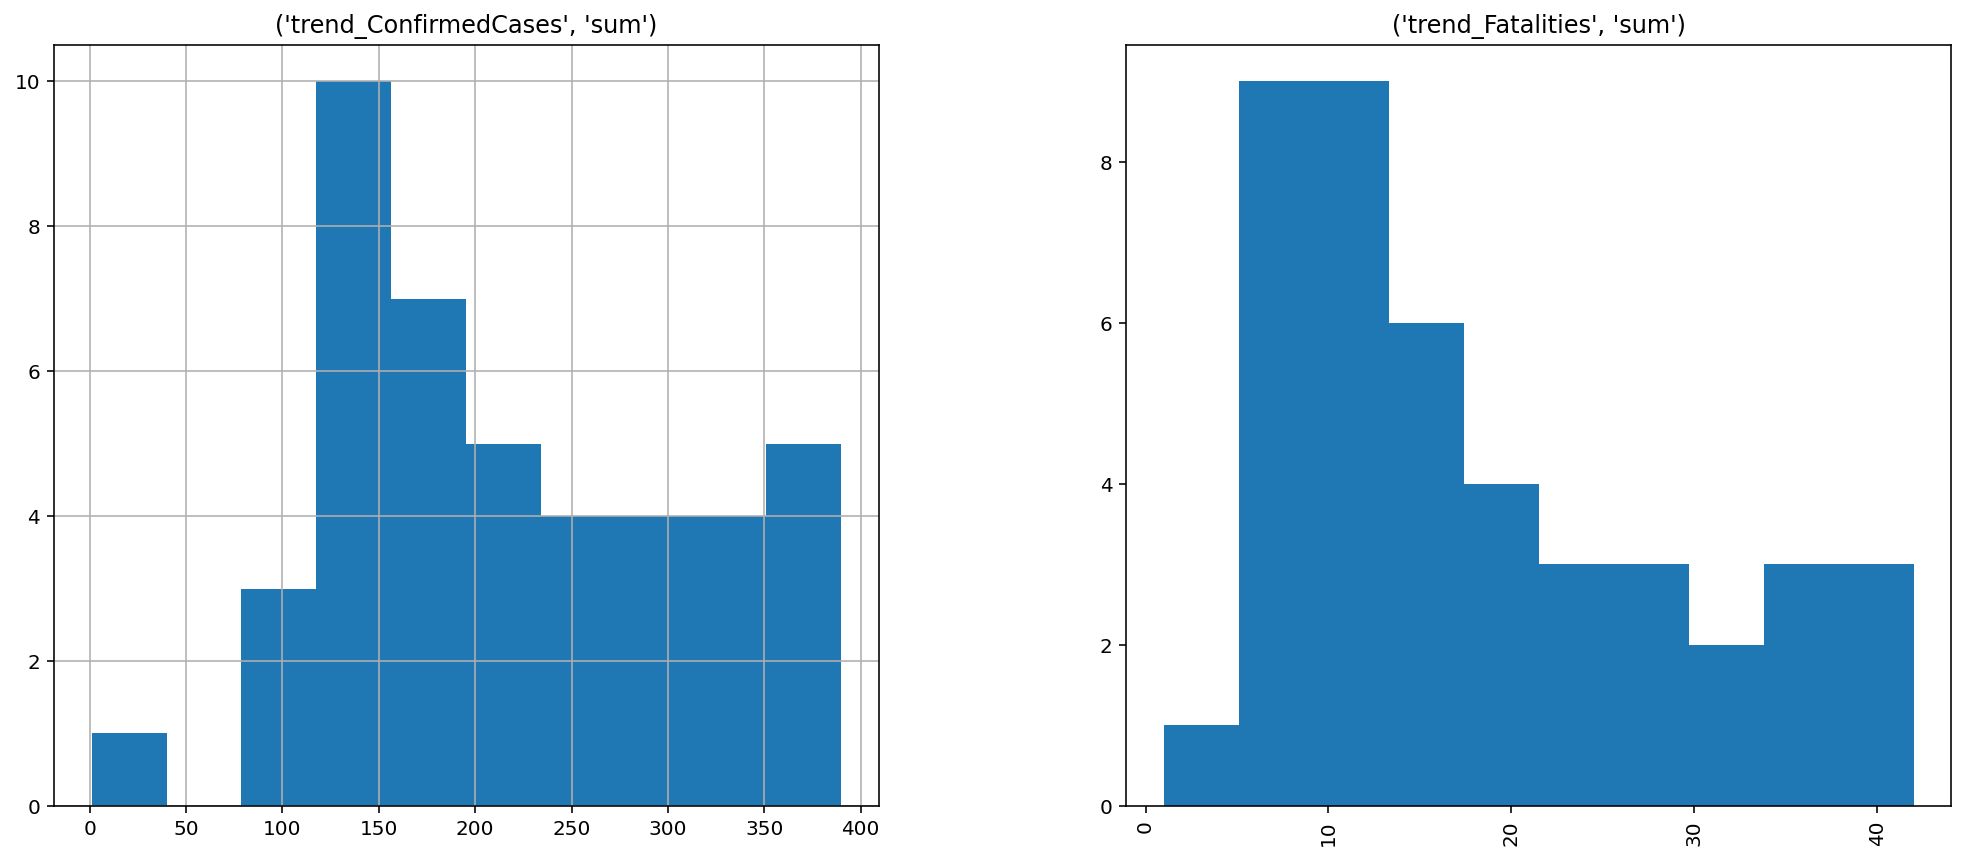

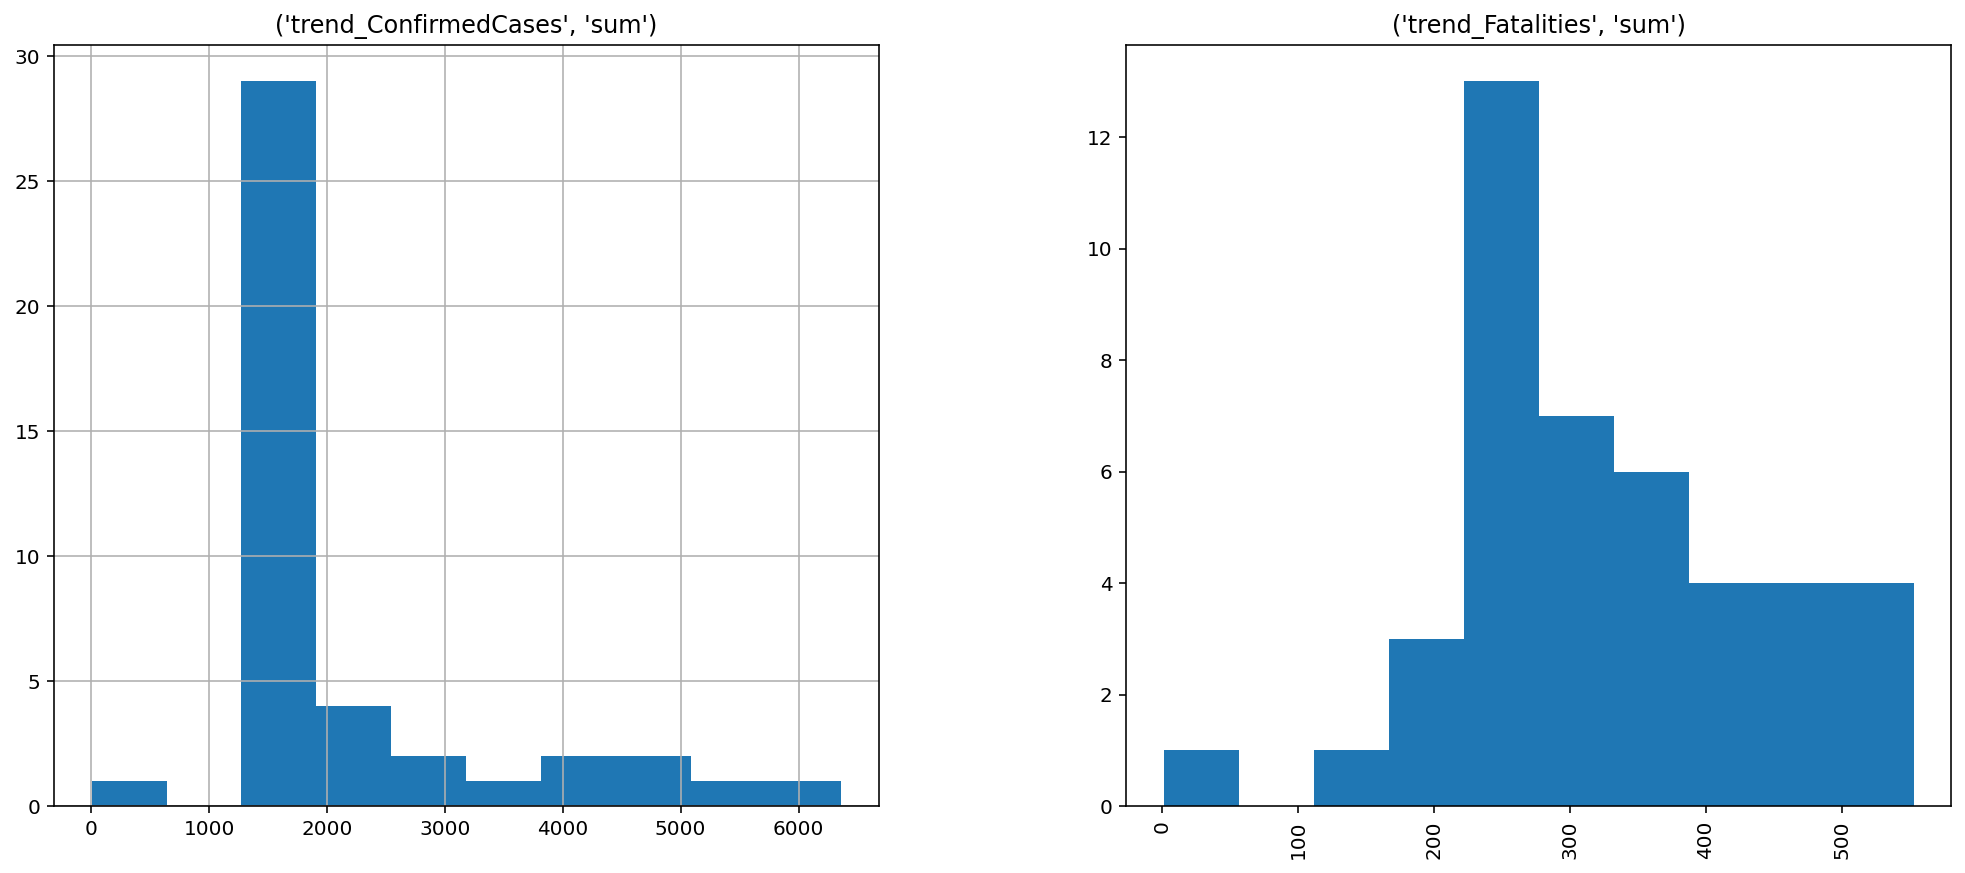

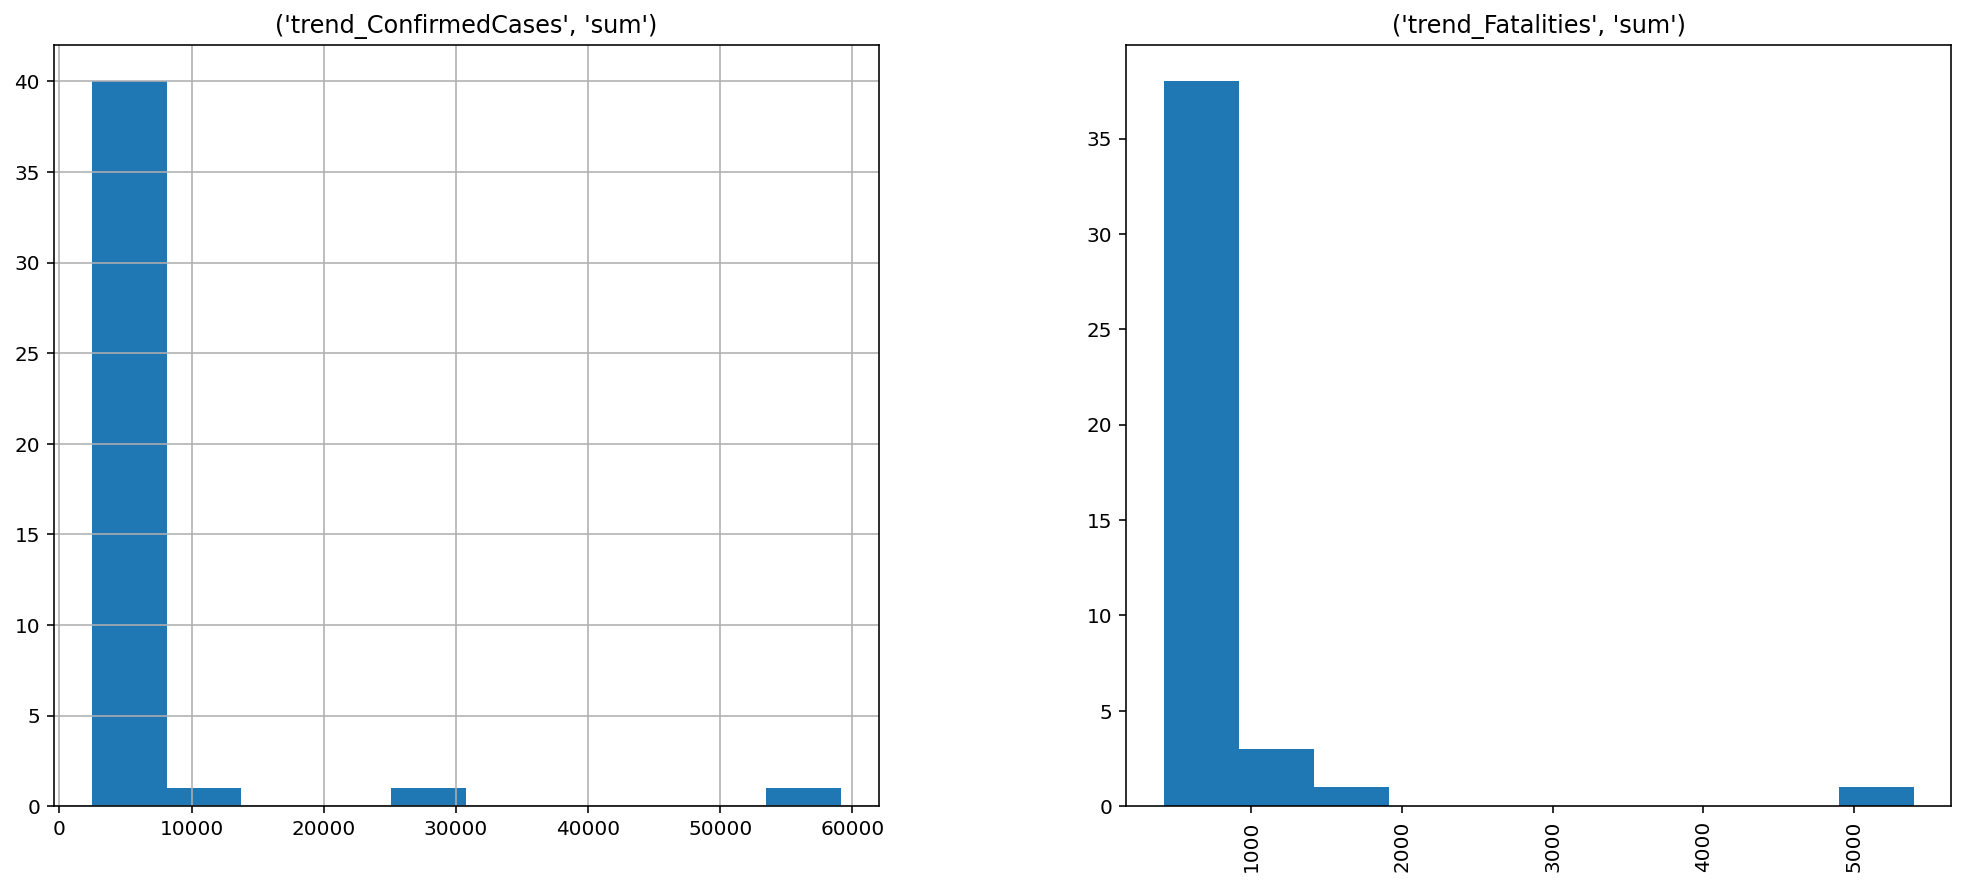

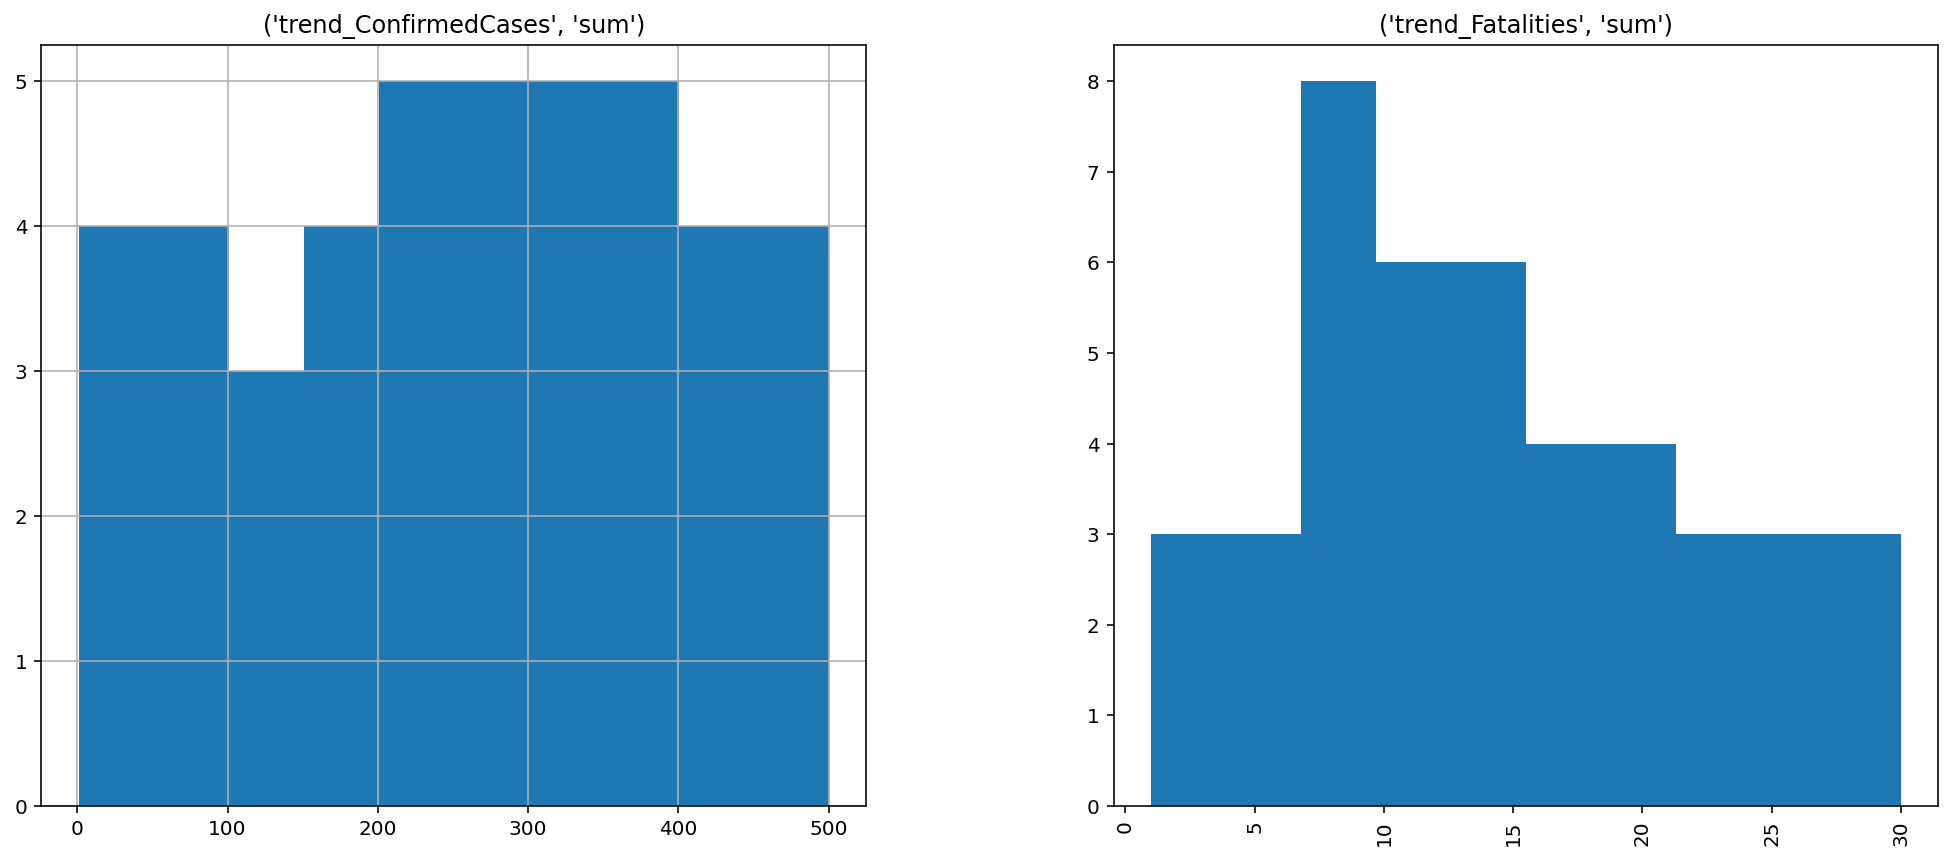

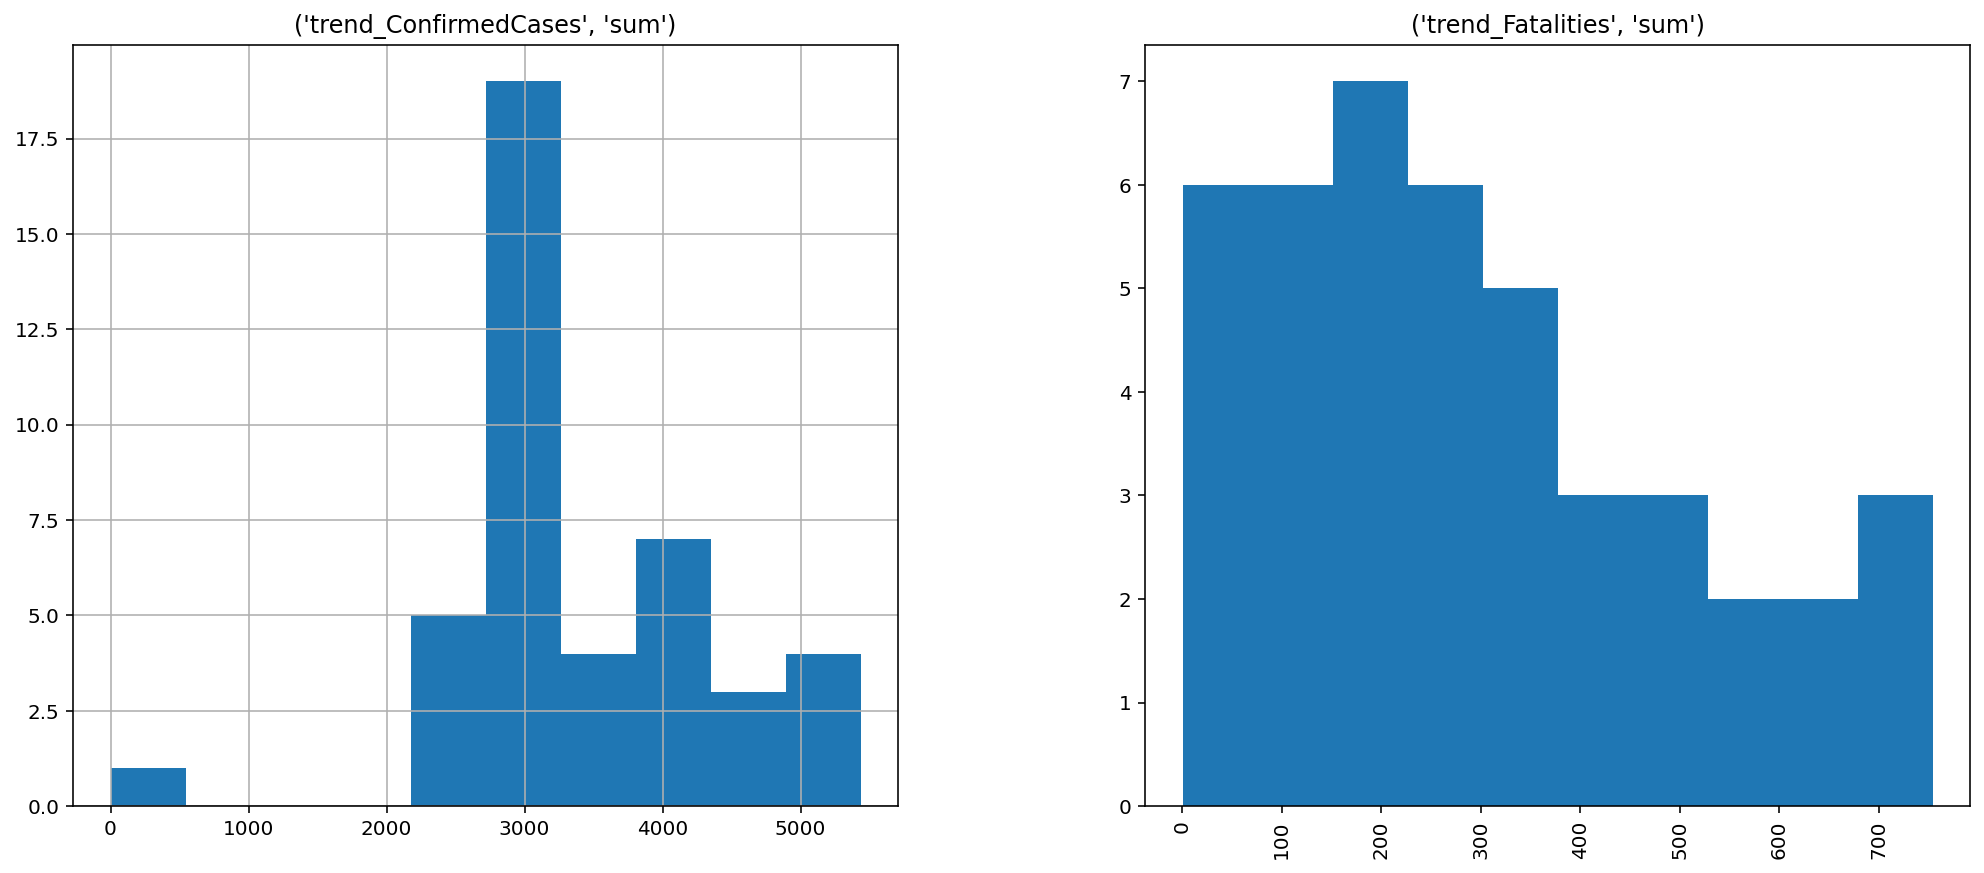

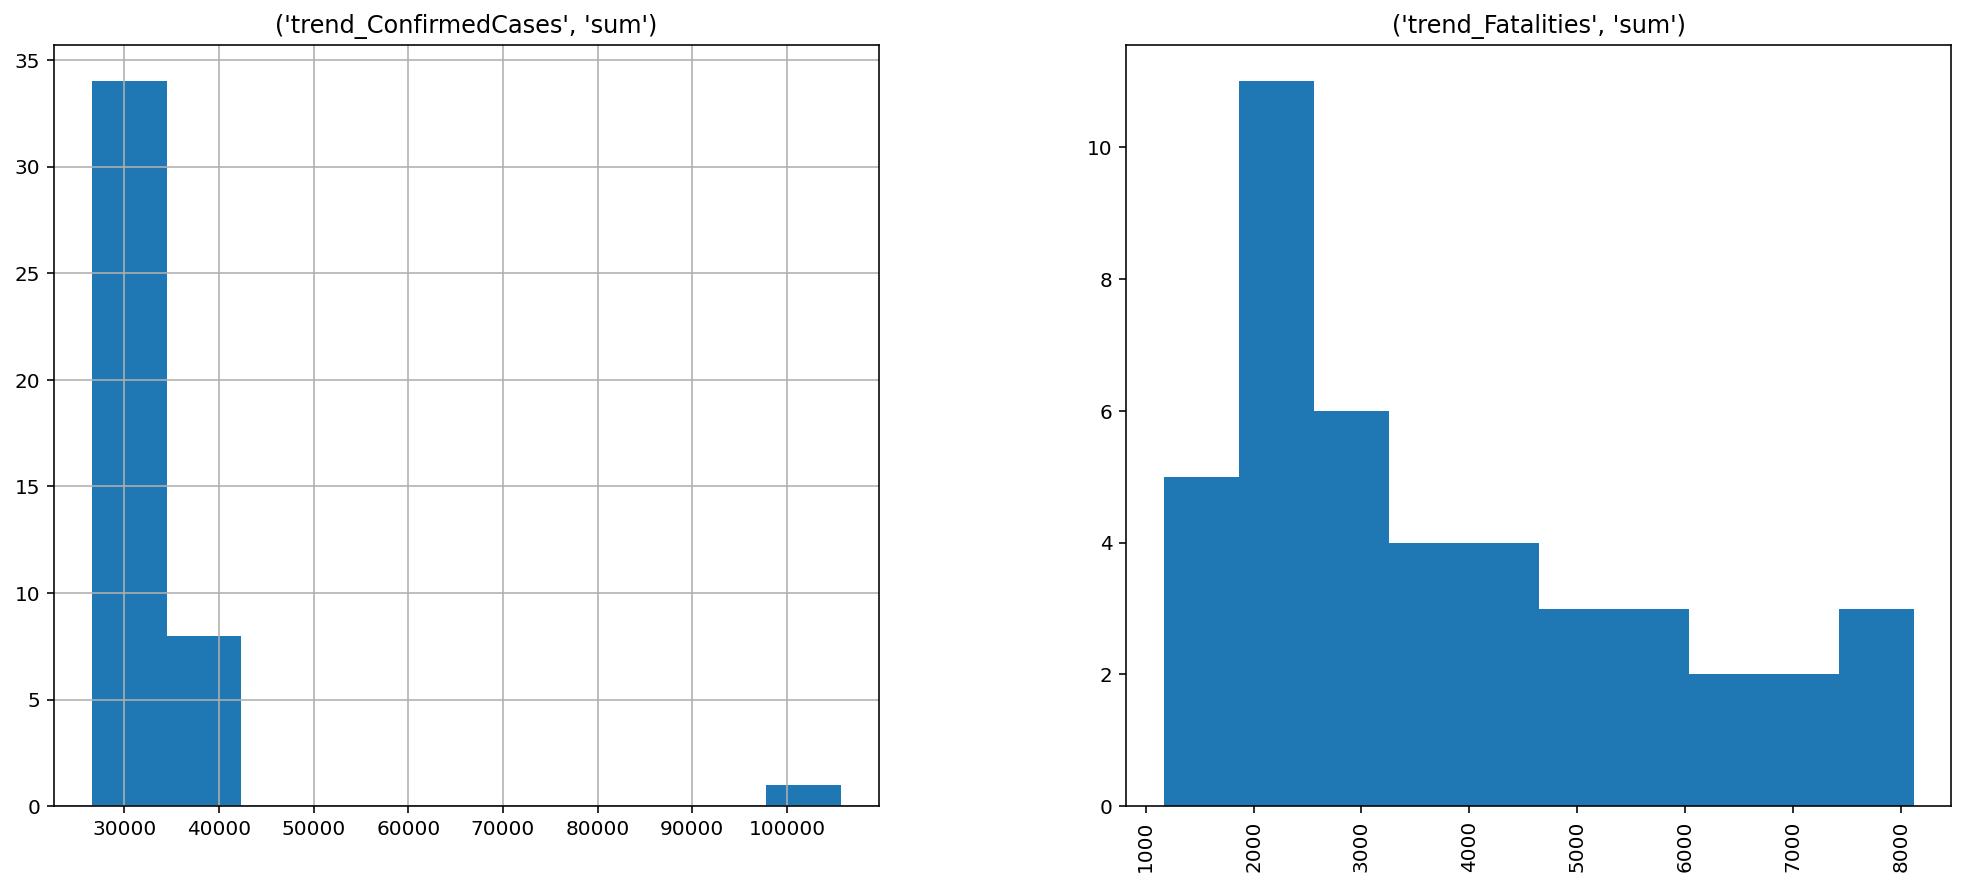

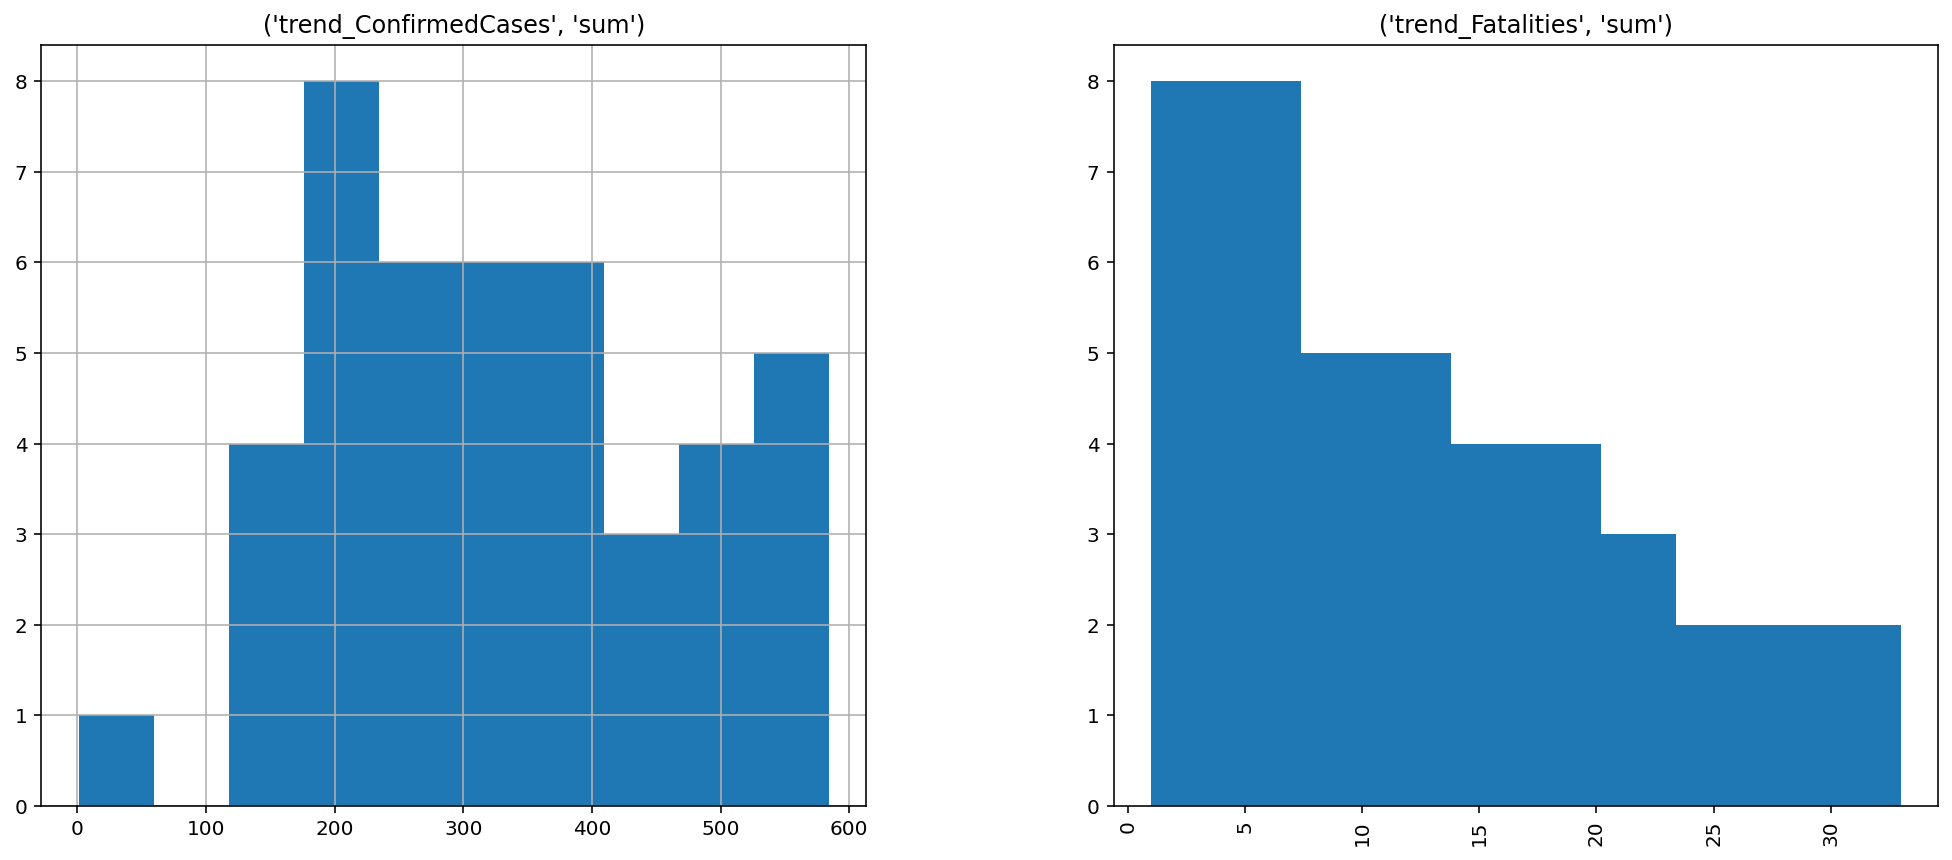

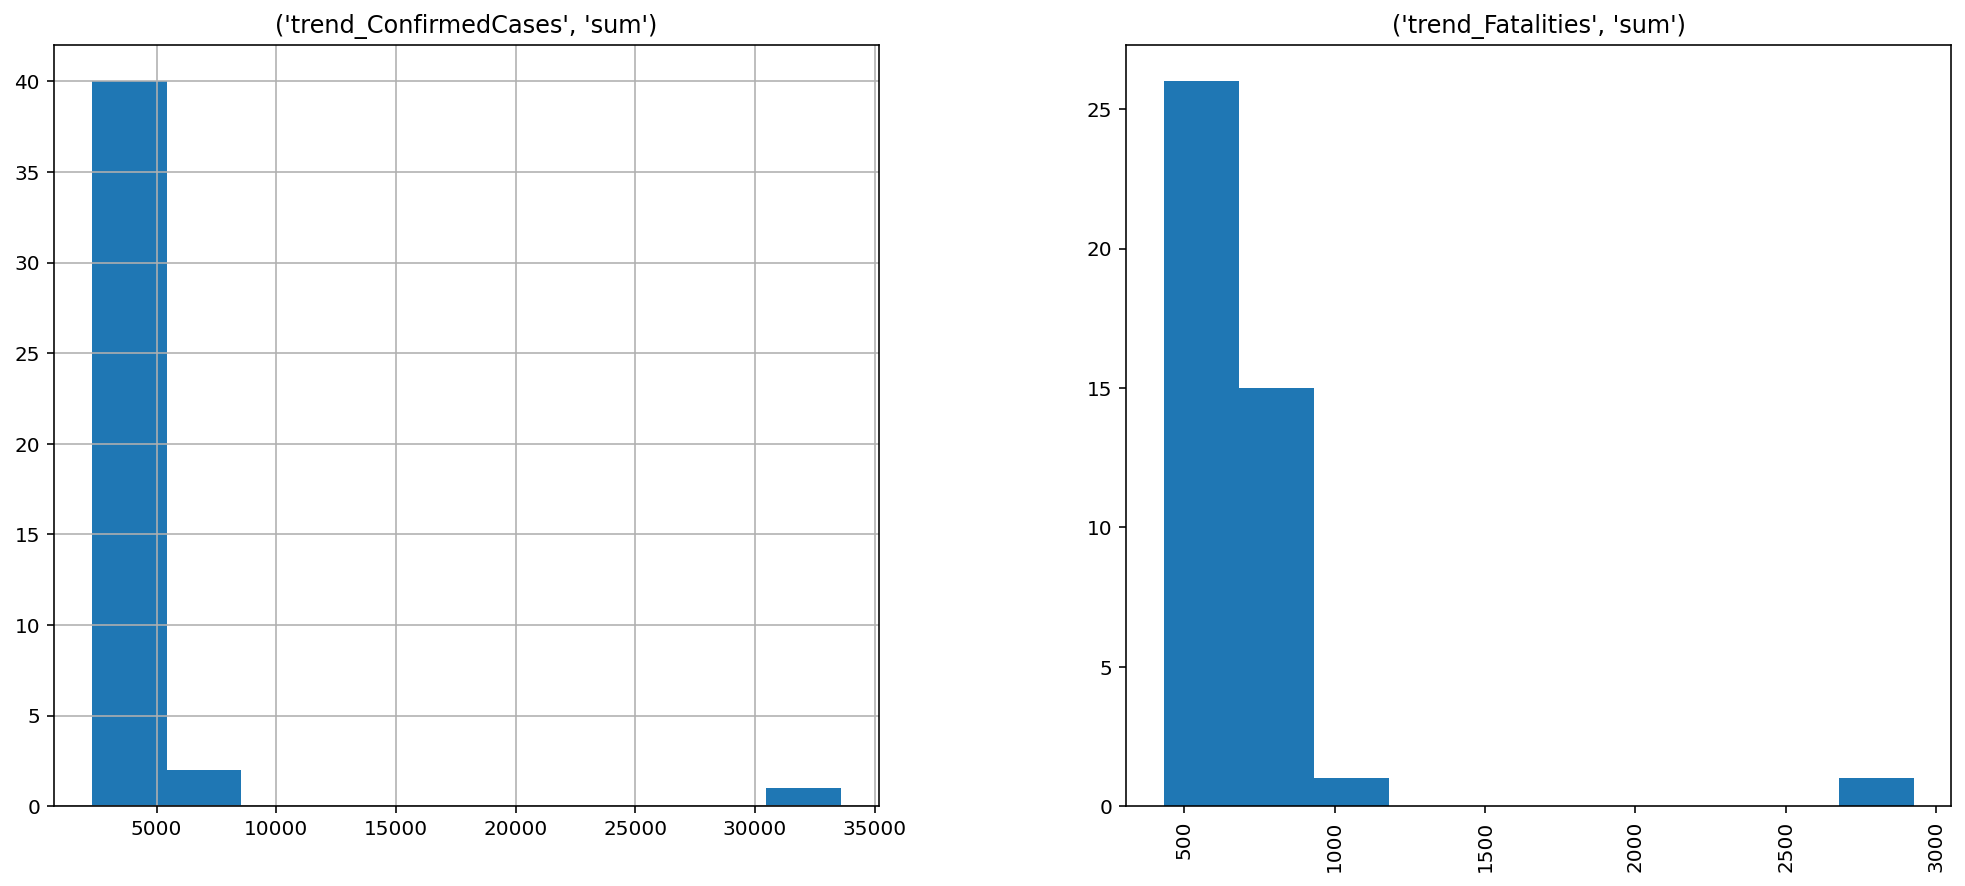

In [99]:
countrylist=['Qatar','Italy','Spain','United Arab Emirates','Egypt','Germany','France','Korea, South','Turkey','US','Saudi Arabia','United Kingdom']
for co in countrylist:
    countryplot_trend(Predicted_data,co)